In [1]:
import itertools
import logging
import os
import pickle
import shutil
import sys
from copy import deepcopy
from importlib import reload

import numpy as np
import parmed as pmd
import ray
from openff.toolkit import ForceField as openffForceField
from openff.toolkit import Molecule as openffMolecule
from openff.toolkit import Topology as openffTopology
from openff.units import unit as openff_unit
from openmmforcefields.generators import (
    GAFFTemplateGenerator,
    SMIRNOFFTemplateGenerator,
)
from rdkit import Chem
from tqdm import tqdm

from openmm import *
from openmm.app import *
from openmm.unit import *

# os.environ["NUMEXPR_MAX_THREADS"] = "8"
os.environ["OE_LICENSE"] = os.environ["HOME"] + "oe_license.txt"


# ray.init(dashboard_port=8838, log_to_driver=True, logging_level="warning")

reload(logging)
logger = logging.getLogger("PL_ABFE-BRD4")
logging.basicConfig(
    format="%(asctime)s %(message)s", datefmt="%Y-%m-%d %I:%M:%S %p", level=logging.INFO
)
stream_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stream_handler)

force_fields = "force_fields"
initial_data = "initial_data"
prepared_data = "prepared_data"
working_data = "/data/ucsd/gilsonlab/jta002/working_data"
results_dirname = "results"

data_dir_names = {
    "initial_data": initial_data,
    "prepared_data": prepared_data,
    "working_data": working_data,
    "results": results_dirname,
}

LICENSE: Could not open license file "oe_license.txt" in local directory
LICENSE: N.B. OE_LICENSE environment variable is not set
LICENSE: N.B. OE_DIR environment variable is not set
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
The OpenEye Toolkits are found to be installed but not licensed and therefore will not be used.
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html
LICENSE: No product keys!
The OpenEye Toolkits are found to be installed but not licensed and therefore will not be used.
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html


## Prepare the system

In [2]:
def create_protein_mol():
    # Load ff14SB to assign charges to the protein
    ff14SB = ForceField("amber/ff14SB.xml")
    protein_pdb = PDBFile(f"{prepared_data}/4lys_protonated_vacuum.pdb")
    protein_system = ff14SB.createSystem(protein_pdb.topology)

    # Get ff14SB-assigned charges into a list
    protein_atomic_charges = []
    for force in protein_system.getForces():
        if isinstance(force, NonbondedForce):
            for i, atom in enumerate(protein_pdb.topology.atoms()):
                protein_atomic_charges.append(force.getParticleParameters(i)[0])

    # A little rdkit sanitization is necessary: we need to generate formal charges
    protein_rdkit_mol = Chem.MolFromMolFile(
        f"{prepared_data}/4lys_protonated_vacuum.sdf", sanitize=False
    )
    for atom in protein_rdkit_mol.GetAtoms():
        if atom.GetSymbol() == "N" and atom.GetExplicitValence() == 4:
            atom.SetFormalCharge(1)
    Chem.SanitizeMol(protein_rdkit_mol)
    Chem.MolToMolFile(
        protein_rdkit_mol, f"{prepared_data}/4lys_protonated_vacuum_clean.sdf"
    )

    protein_mol = openffMolecule.from_file(
        f"{prepared_data}/4lys_protonated_vacuum_clean.sdf"
    )

    # When translated to OpenFF Molecule, we have 13 extra hydrogens for some reason,
    # so here we create a new molecule that doesn't have these extra Hs.
    # The way we do this assumes all of the extraneous Hs are at the end of the atoms list
    protein_mol_new = openffMolecule()
    protein_mol_new.name = "4LYS"

    for i in range(protein_pdb.topology.getNumAtoms()):
        atom = protein_mol.atoms[i]
        metadata = {
            "residue_name": list(protein_pdb.topology.atoms())[i].residue.name,
            "residue_number": list(protein_pdb.topology.atoms())[i].residue.id,
        }
        protein_mol_new.add_atom(
            atom.atomic_number,
            atom.formal_charge,
            atom.is_aromatic,
            stereochemistry=atom.stereochemistry,
            name=list(protein_pdb.topology.atoms())[i].name,
            metadata=metadata,
        )

    # Add bonds to the new molecule
    for bond in protein_mol.bonds:
        if (
            bond.atom1_index < protein_pdb.topology.getNumAtoms()
            and bond.atom2_index < protein_pdb.topology.getNumAtoms()
        ):
            protein_mol_new.add_bond(
                bond.atom1_index,
                bond.atom2_index,
                bond.bond_order,
                bond.is_aromatic,
                stereochemistry=bond.stereochemistry,
                fractional_bond_order=bond.fractional_bond_order,
            )

    # Add conformer
    protein_mol_new.add_conformer(
        coordinates=protein_mol.conformers[0][: protein_pdb.topology.getNumAtoms(), :]
    )

    del protein_mol
    protein_mol = protein_mol_new
    assert protein_mol.n_atoms == protein_pdb.topology.getNumAtoms()
    assert protein_mol.n_bonds == protein_pdb.topology.getNumBonds()

    # Assign ff14SB charges to the OpenFF Molecule
    protein_mol.partial_charges = [
        ac.value_in_unit(elementary_charge) for ac in protein_atomic_charges
    ] * openff_unit.elementary_charge
    # protein_mol.generate_unique_atom_names()

    sys.setrecursionlimit(10000)
    with open(f"{prepared_data}/protein_mol.pickle", "wb") as f:
        pickle.dump(protein_mol, f)

    return protein_mol


try:
    with open(f"{prepared_data}/protein_mol.pickle", "rb") as f:
        protein_mol = pickle.load(f)
except:
    protein_mol = create_protein_mol()

In [3]:
def create_ligand_mol():
    ligand_mol = openffMolecule.from_file(
        f"{prepared_data}/4lys_D_2SJ_protonated_vacuum.mol2", file_format="mol2"
    )
    ligand_mol.assign_partial_charges(
        partial_charge_method="am1bcc", use_conformers=ligand_mol.conformers
    )
    for atom in ligand_mol.atoms:
        atom.metadata["residue_name"] = "2SJ"

    sys.setrecursionlimit(10000)
    with open(f"{prepared_data}/ligand_mol.pickle", "wb") as f:
        pickle.dump(ligand_mol, f)

    return ligand_mol


try:
    with open(f"{prepared_data}/ligand_mol.pickle", "rb") as f:
        ligand_mol = pickle.load(f)
except:
    ligand_mol = create_ligand_mol()

In [8]:
from openmmforcefields.generators import (
    GAFFTemplateGenerator,
)

gaff = GAFFTemplateGenerator(molecules=ligand_mol)

forcefield = ForceField(
    "amber/protein.ff14SB.xml",
    "amber/tip3p_standard.xml",
    "amber/tip3p_HFE_multivalent.xml",
)
forcefield.registerTemplateGenerator(gaff.generator)

model.addSolvent(forcefield, padding=1.2*nanometers)

In [10]:
implicit_solvent = False

if implicit_solvent:
    force_field = openffForceField(
        "openff-2.2.0.offxml",
        "ff14sb_off_impropers_0.0.4.offxml",
        "force_fields/GBSA-OBC2.offxml",
        load_plugins=True,
        allow_cosmetic_attributes=True,
    )
    
    openff_topology = openffTopology.from_molecules(molecules=[protein_mol, ligand_mol])
    system = force_field.create_openmm_system(
        openff_topology,
        partial_bond_orders_from_molecules=[protein_mol, ligand_mol],
        charge_from_molecules=[protein_mol, ligand_mol],
        allow_nonintegral_charges=True,
    )
    
    openmm_positions = Quantity(
        value=[
            Vec3(
                pos[0].m_as(openff_unit.nanometer),
                pos[1].m_as(openff_unit.nanometer),
                pos[2].m_as(openff_unit.nanometer),
            )
            for pos in openff_topology.get_positions()
        ],
        unit=nanometer,
    )
    model = Modeller(
        openff_topology.to_openmm(ensure_unique_atom_names=False), openmm_positions
    )

else:
    from openmmforcefields.generators import (
        GAFFTemplateGenerator,
    )
    
    gaff = GAFFTemplateGenerator(molecules=ligand_mol)
    
    forcefield = ForceField(
        "amber/protein.ff14SB.xml",
        "amber/tip3p_standard.xml",
        "amber/tip3p_HFE_multivalent.xml",
    )
    forcefield.registerTemplateGenerator(gaff.generator)

In [5]:
from paprika.build import align

structure = pmd.openmm.load_topology(
    model.topology,
    system,
    xyz=openmm_positions,
    condense_atom_types=False,
)

A1 = ":2SJ@C5"  # ":2SJ@C10x"
A2 = ":2SJ@C22"  # ":2SJ@C16x"

align.translate_to_origin(structure)
align.zalign(structure, A1, A2)

2024-12-18 01:15:49 PM Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.
2024-12-18 01:15:49 PM 
****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************

2024-12-18 01:15:49 PM JAX detected. Using JAX acceleration.
2024-12-18 01:15:54 PM Moving :2SJ@C5 (1 atoms) to the origin...
2024-12-18 01:15:54

<Structure 2131 atoms; 125 residues; 2163 bonds; parameterized>

In [6]:
P1 = f":{110-42}@CA"  # ":ILE@C365x"
P2 = f":{131-42}@CA"  # ":THR@C485x"
P3 = f":{157-42}@CA"  # ":PHE@C619x"

L1 = ":2SJ@O3"  # ":2SJ@O4x"
L2 = ":2SJ@C10"  # ":2SJ@C6x"
L3 = ":2SJ@C19"  # ":2SJ@C19x"

In [7]:
# Ensure that P1 lies on the YZ plane
P1_original = structure[P1].coordinates[0]
P1_rotated = np.array([0, np.linalg.norm(P1_original[:2]), P1_original[2]])

theta_initial = np.arctan2(P1_original[1], P1_original[0])
theta_final = np.arctan2(P1_rotated[1], P1_rotated[0])

# Calculate the rotation angle in radians
delta_theta = theta_final - theta_initial
align.rotate_around_axis(structure, "z", delta_theta)

with open(f"{prepared_data}/aligned_structure.pickle", "wb") as f:
    pickle.dump(deepcopy(structure), f)

# Make sure that the new x coordinate of P1 is close to 0
print(f"The new x coordinate of P1 is: {structure[P1].coordinates[0][0]:0.3f}")

model = Modeller(model.topology, structure.positions.in_units_of(nanometer))

if not implicit_solvent:
    

# N1_pos is same x and y as L1, but 5 Angstroms less in z
N1_pos = Quantity(
    value=Vec3(
        0, 0, (structure[L1].positions[0][2] - 5 * angstroms).value_in_unit(nanometer)
    ),
    unit=nanometer,
)
# N2_pos is same x and z as N1_pos, but with a y value equal to to the y value of P1
N2_pos = Quantity(
    value=Vec3(
        0,
        structure[P1].positions[0][1].value_in_unit(nanometer),
        N1_pos[2].value_in_unit(nanometer),
    ),
    unit=nanometer,
)

N3_pos = Quantity(
    value=Vec3(
        0,
        N2_pos[1].value_in_unit(nanometer),
        (N2_pos[2] + (N2_pos[2] - structure[P1].positions[0][2])).value_in_unit(
            nanometer
        ),
    ),
    unit=nanometer,
)

The new x coordinate of P1 is: 0.000


In [8]:
# Give the dummy atoms mass of lead (207.2) and set the nonbonded forces for the dummy atoms to have charge 0 and LJ parameters epsilon=sigma=0.
for force in system.getForces():
    if isinstance(force, openmm.NonbondedForce):
        system.addParticle(mass=207.2)
        system.addParticle(mass=207.2)
        system.addParticle(mass=207.2)
        force.addParticle(0, 0, 0)
        force.addParticle(0, 0, 0)
        force.addParticle(0, 0, 0)

with open(f"{prepared_data}/aligned_dummy_system.xml", "w") as f:
    f.write(XmlSerializer.serialize(system))

all_positions = model.positions
all_positions.append(N1_pos)
all_positions.append(N2_pos)
all_positions.append(N3_pos)

chain = model.topology.addChain("5")
dummy_res1 = model.topology.addResidue(name="DM1", chain=chain, id="500")
dummy_res2 = model.topology.addResidue(name="DM2", chain=chain, id="501")
dummy_res3 = model.topology.addResidue(name="DM3", chain=chain, id="502")

model.topology.addAtom("DUM", Element.getBySymbol("Pb"), dummy_res1)
model.topology.addAtom("DUM", Element.getBySymbol("Pb"), dummy_res2)
model.topology.addAtom("DUM", Element.getBySymbol("Pb"), dummy_res3)

with open(f"{prepared_data}/aligned_dummy_structure.cif", "w+") as f:
    PDBxFile.writeFile(model.topology, all_positions, file=f, keepIds=True)
with open(f"{prepared_data}/aligned_dummy_structure.pdb", "w+") as f:
    PDBFile.writeFile(model.topology, all_positions, file=f, keepIds=True)

aligned_dummy_structure = pmd.openmm.load_topology(
    model.topology, system, xyz=all_positions, condense_atom_types=False
)

In [9]:
N1 = ":DM1@DUM"
N2 = ":DM2@DUM"
N3 = ":DM3@DUM"

ASP88_1 = f":{88-42}@N"  # Asp88 N
ASP88_2 = f":{88-42}@CA"  # Asp88 C_alpha
ASP88_3 = f":{88-42}@C"  # Asp88 C
ASP88_4 = f":{89-42}@N"  # Ala89 N

In [10]:
for mask in [
    A1,
    A2,
    P1,
    P2,
    P3,
    L1,
    L2,
    L3,
    N1,
    N2,
    N3,
    ASP88_1,
    ASP88_2,
    ASP88_3,
    ASP88_4,
]:
    try:
        assert len(aligned_dummy_structure[mask].positions) == 1
    except:
        print(mask)

In [11]:
deltaG_values = {}

## Calculate $\Delta G_{attach,p}$

In [12]:
from paprika import restraints
from paprika.restraints.openmm import apply_dat_restraint, apply_positional_restraints

block_length = 5
block_separators = [0, 0.003, 0.010, 0.025, 0.050, 0.100, 0.200, 0.500, 1.000]
attach_p_fractions = []
i = 0
while i < len(block_separators):
    try:
        attach_p_fractions += np.linspace(
            block_separators[i], block_separators[i + 1], block_length
        ).tolist()[:-1]
        i += 1
    except IndexError:
        attach_p_fractions += [1.0]
        break

attach_p_fractions = np.array(attach_p_fractions)

attach_p_restraints_static = []


Asp88_torsion_wall_static = restraints.static_DAT_restraint(
    [ASP88_1, ASP88_2, ASP88_3, ASP88_4],
    [len(attach_p_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure_protein_only.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
Asp88_torsion_wall_static.custom_restraint_values = {
    "r2": 55,
    "r3": 179.9,
    "rk2": 20,
    "rk3": 0.0,
}

attach_p_restraints_static.append(Asp88_torsion_wall_static)

attach_p_restraints_dynamic = []


P1_P2_distance = restraints.DAT_restraint()
P1_P2_distance.mask1 = P1
P1_P2_distance.mask2 = P2
P1_P2_distance.topology = aligned_dummy_structure
P1_P2_distance.auto_apr = False
P1_P2_distance.continuous_apr = False
P1_P2_distance.amber_index = False
P1_P2_vector = (
    aligned_dummy_structure[P2].positions[0] - aligned_dummy_structure[P1].positions[0]
)
P1_P2_vector = [val.value_in_unit(angstrom) for val in P1_P2_vector]
P1_P2_distance.attach["target"] = openff_unit.Quantity(
    value=np.linalg.norm(P1_P2_vector), units=openff_unit.angstrom
)
P1_P2_distance.attach["fraction_list"] = attach_p_fractions * 100
P1_P2_distance.attach["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
P1_P2_distance.initialize()

attach_p_restraints_dynamic.append(P1_P2_distance)


P2_P3_distance = restraints.DAT_restraint()
P2_P3_distance.mask1 = P2
P2_P3_distance.mask2 = P3
P2_P3_distance.topology = aligned_dummy_structure
P2_P3_distance.auto_apr = False
P2_P3_distance.continuous_apr = False
P2_P3_distance.amber_index = False
P2_P3_vector = (
    aligned_dummy_structure[P3].positions[0] - aligned_dummy_structure[P2].positions[0]
)
P2_P3_vector = [val.value_in_unit(angstrom) for val in P2_P3_vector]
P2_P3_distance.attach["target"] = openff_unit.Quantity(
    value=np.linalg.norm(P2_P3_vector), units=openff_unit.angstrom
)
P2_P3_distance.attach["fraction_list"] = attach_p_fractions * 100
P2_P3_distance.attach["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
P2_P3_distance.initialize()

attach_p_restraints_dynamic.append(P2_P3_distance)


P1_P3_distance = restraints.DAT_restraint()
P1_P3_distance.mask1 = P1
P1_P3_distance.mask2 = P3
P1_P3_distance.topology = aligned_dummy_structure
P1_P3_distance.auto_apr = False
P1_P3_distance.continuous_apr = False
P1_P3_distance.amber_index = False
P1_P3_vector = (
    aligned_dummy_structure[P3].positions[0] - aligned_dummy_structure[P1].positions[0]
)
P1_P3_vector = [val.value_in_unit(angstrom) for val in P1_P3_vector]
P1_P3_distance.attach["target"] = openff_unit.Quantity(
    value=np.linalg.norm(P1_P3_vector), units=openff_unit.angstrom
)
P1_P3_distance.attach["fraction_list"] = attach_p_fractions * 100
P1_P3_distance.attach["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
P1_P3_distance.initialize()

attach_p_restraints_dynamic.append(P1_P3_distance)


Asp88_torsion = restraints.DAT_restraint()
Asp88_torsion.mask1 = ASP88_1
Asp88_torsion.mask2 = ASP88_2
Asp88_torsion.mask3 = ASP88_3
Asp88_torsion.mask4 = ASP88_4
Asp88_torsion.topology = aligned_dummy_structure
Asp88_torsion.auto_apr = False
Asp88_torsion.continuous_apr = False
Asp88_torsion.amber_index = False
Asp88_torsion.attach["target"] = 80  # Degrees
Asp88_torsion.attach["fraction_list"] = attach_p_fractions * 100
Asp88_torsion.attach["fc_final"] = 20  # kilocalorie/(mole*radian**2)
Asp88_torsion.initialize()

attach_p_restraints_dynamic.append(Asp88_torsion)


# Check restraints and create windows from dynamic restraints
restraints.restraints.check_restraints(attach_p_restraints_static)
restraints.restraints.check_restraints(attach_p_restraints_dynamic)
window_list = restraints.utils.create_window_list(attach_p_restraints_dynamic)

2024-12-18 12:33:02 PM Restraints appear to be consistent
2024-12-18 12:33:02 PM Restraints appear to be consistent


In [13]:
from simulate import run_heating_and_equil, run_minimization, run_production

simulation_parameters = {
    "k_pos": 50 * kilocalorie / (mole * angstrom**2),
    "friction": 1 / picosecond,
    "timestep": 1 * femtoseconds,
    "tolerance": 0.0001 * kilojoules_per_mole / nanometer,
    "maxIterations": 0,
}

# futures = [
#    run_minimization.remote(
#        window,
#        system,
#        model,
#        attach_p_restraints_static + attach_p_restraints_dynamic,
#        "attach_p_restraints",
#        simulation_parameters=simulation_parameters,
#        data_dir_names=data_dir_names,
#    )
#    for window in window_list
# ]
#_ = ray.get(futures)


simulation_parameters = {
    "temperatures": np.arange(0.0, 298.15, 10.0),
    "time_per_temp": 20 * picoseconds,
    "equilibration_time": 40 * nanoseconds,
    "friction": 1 / picosecond,
    "timestep": 1 * femtoseconds,
}

# futures = [
#    run_heating_and_equil.remote(
#        window,
#        system,
#        model,
#        "attach_p_restraints",
#        simulation_parameters=simulation_parameters,
#        data_dir_names=data_dir_names,
#    )
#    for window in window_list
# ]
#_ = ray.get(futures)


simulation_parameters = {
    "temperature": 298.15,
    "friction": 1 / picosecond,
    "timestep": 2 * femtoseconds,
    "production_time": 100 * nanoseconds,
    "dcd_reporter_frequency": 1000,
    "state_reporter_frequency": 1000,
}

# futures = [
#    run_production.remote(
#        window,
#        system,
#        model,
#        "attach_p_restraints",
#        simulation_parameters=simulation_parameters,
#        data_dir_names=data_dir_names,
#    )
#    for window in window_list
# ]
#_ = ray.get(futures)

In [14]:
import paprika.analysis as analysis

free_energy = analysis.fe_calc()
free_energy.topology = "heated.pdb"
free_energy.trajectory = "production.dcd"
free_energy.path = f"{working_data}/attach_p_restraints"
free_energy.restraint_list = attach_p_restraints_static + attach_p_restraints_dynamic
free_energy.collect_data(single_topology=False)
free_energy.methods = ["mbar-autoc"]
free_energy.boot_cycles = 1000
free_energy.compute_free_energy(phases=["attach"])
free_energy.save_results(f"{results_dirname}/deltaG_attach_p.json", overwrite=True)

deltaG_attach_p = {
   "fe": free_energy.results["attach"]["mbar-autoc"]["fe"],
   "sem": free_energy.results["attach"]["mbar-autoc"]["sem"],
   "fe_matrix": free_energy.results["attach"]["mbar-autoc"]["fe_matrix"],
   "sem_matrix": free_energy.results["attach"]["mbar-autoc"]["sem_matrix"],
}
deltaG_values["deltaG_attach_p"] = deltaG_attach_p
print(deltaG_attach_p)

2024-12-15 05:32:10 PM Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-15 05:32:10 PM Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-12-15 05:32:48 PM Reached a solution to within tolerance with hybr
2024-12-15 05:32:48 PM Solution found within tolerance!
2024-12-15 05:32:48 PM Final gradient norm: 4.01e-07
2024-12-15 05:33:31 PM Reached a solution to within tolerance with hybr
2024-12-15 05:33:31 PM Solution found within tolerance!
2024-12-15 05:33:31 PM Final gradient norm: 4.01e-07


{'fe': <Quantity(18.7902754, 'kilocalorie / mole')>, 'sem': <Quantity(0.00618331237, 'kilocalorie / mole')>, 'fe_matrix': <Quantity([[  0.           4.36602616   7.24602027 ...  18.44233653  18.6289989
   18.7902754 ]
 [ -4.36602616   0.           2.87999411 ...  14.07631037  14.26297275
   14.42424925]
 [ -7.24602027  -2.87999411   0.         ...  11.19631626  11.38297864
   11.54425514]
 ...
 [-18.44233653 -14.07631037 -11.19631626 ...   0.           0.18666238
    0.34793888]
 [-18.6289989  -14.26297275 -11.38297864 ...  -0.18666238   0.
    0.1612765 ]
 [-18.7902754  -14.42424925 -11.54425514 ...  -0.34793888  -0.1612765
    0.        ]], 'kilocalorie / mole')>, 'sem_matrix': <Quantity([[0.         0.00180655 0.0036678  ... 0.00615331 0.00616902 0.00618331]
 [0.00180655 0.         0.00246266 ... 0.0054976  0.00551518 0.00553116]
 [0.0036678  0.00246266 0.         ... 0.00447774 0.00449931 0.00451888]
 ...
 [0.00615331 0.0054976  0.00447774 ... 0.         0.00013434 0.00025489]
 [0.

## Calculate $\Delta G_{attach,l}$

In [13]:
from paprika import restraints
from paprika.restraints.openmm import apply_dat_restraint, apply_positional_restraints

block_length = 5
block_separators = [0, 0.003, 0.010, 0.025, 0.050, 0.100, 0.200, 0.500, 1.000]
attach_l_fractions = []
i = 0
while i < len(block_separators):
    try:
        attach_l_fractions += np.linspace(
            block_separators[i], block_separators[i + 1], block_length
        ).tolist()[:-1]
        i += 1
    except IndexError:
        attach_l_fractions += [1.0]
        break

attach_l_fractions = np.array(attach_l_fractions)

# P1-P2-P3 distances, Asp88 ψ dihedral, D2, A3, A4, T4, T5, T6 (Fig. 1a)
P1_P2_distance = restraints.static_DAT_restraint(
    [P1, P2],
    [len(attach_l_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
P2_P3_distance = restraints.static_DAT_restraint(
    [P2, P3],
    [len(attach_l_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
P1_P3_distance = restraints.static_DAT_restraint(
    [P1, P2],
    [len(attach_l_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
Asp88_torsion = restraints.static_DAT_restraint(
    [ASP88_1, ASP88_2, ASP88_3, ASP88_4],
    [len(attach_l_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    20 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
P1_N2_distance = restraints.static_DAT_restraint(
    [P1, N2],
    [len(attach_l_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
P1_N2_N1_angle = restraints.static_DAT_restraint(
    [P1, N2, N1],
    [len(attach_l_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
P2_P1_N2_angle = restraints.static_DAT_restraint(
    [P2, P1, N2],
    [len(attach_l_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
P1_N2_N1_N3_torsion = restraints.static_DAT_restraint(
    [P1, N2, N1, N3],
    [len(attach_l_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
P2_P1_N2_N1_torsion = restraints.static_DAT_restraint(
    [P2, P1, N2, N1],
    [len(attach_l_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
P3_P2_P1_N2_torsion = restraints.static_DAT_restraint(
    [P2, P1, N2, N1],
    [len(attach_l_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)

Asp88_torsion_wall_static = restraints.static_DAT_restraint(
    [ASP88_1, ASP88_2, ASP88_3, ASP88_4],
    [len(attach_l_restraints), 0, 0],
    "prepared_data/aligned_dummy_structure_protein_only.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
Asp88_torsion_wall_static.custom_restraint_values = {
    "r2": 55,
    "r3": 179.9,
    "rk2": 20,
    "rk3": 0.0,
}

attach_l_restraints_static = [
    P1_P2_distance,
    P2_P3_distance,
    P1_P3_distance,
    Asp88_torsion,
    P1_N2_distance,
    P1_N2_N1_angle,
    P2_P1_N2_angle,
    P1_N2_N1_N3_torsion,
    P2_P1_N2_N1_torsion,
    P3_P2_P1_N2_torsion,
    Asp88_torsion_wall_static,
]

# L1-L2-L3 distances, ligand dihedral when present (NOT PRESENT FOR THIS LIGAND), D1, A1, A2, T1, T2, T3 (Fig. 1a)
attach_l_restraints_dynamic = []

# L1-L2
L1_L2_distance = restraints.DAT_restraint()
L1_L2_distance.mask1 = L1
L1_L2_distance.mask2 = L2
L1_L2_distance.topology = aligned_dummy_structure
L1_L2_distance.auto_apr = False
L1_L2_distance.continuous_apr = False
L1_L2_distance.amber_index = False
L1_L2_vector = (
    aligned_dummy_structure[L2].positions[0] - aligned_dummy_structure[L1].positions[0]
)
L1_L2_vector = [val.value_in_unit(angstrom) for val in L1_L2_vector]
L1_L2_distance.attach["target"] = openff_unit.Quantity(
    value=np.linalg.norm(L1_L2_vector), units=openff_unit.angstrom
)
L1_L2_distance.attach["fraction_list"] = attach_l_fractions * 100
L1_L2_distance.attach["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
L1_L2_distance.attach["fc_initial"] = 0
L1_L2_distance.initialize()
attach_l_restraints_dynamic.append(L1_L2_distance)

# L2-L3
L2_L3_distance = restraints.DAT_restraint()
L2_L3_distance.mask1 = L2
L2_L3_distance.mask2 = L3
L2_L3_distance.topology = aligned_dummy_structure
L2_L3_distance.auto_apr = False
L2_L3_distance.continuous_apr = False
L2_L3_distance.amber_index = False
L2_L3_vector = (
    aligned_dummy_structure[L3].positions[0] - aligned_dummy_structure[L2].positions[0]
)
L2_L3_vector = [val.value_in_unit(angstrom) for val in L2_L3_vector]
L2_L3_distance.attach["target"] = openff_unit.Quantity(
    value=np.linalg.norm(L2_L3_vector), units=openff_unit.angstrom
)
L2_L3_distance.attach["fraction_list"] = attach_l_fractions * 100
L2_L3_distance.attach["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
L2_L3_distance.attach["fc_initial"] = 0
L2_L3_distance.initialize()
attach_l_restraints_dynamic.append(L2_L3_distance)

# L1-L3
L1_L3_distance = restraints.DAT_restraint()
L1_L3_distance.mask1 = L1
L1_L3_distance.mask2 = L3
L1_L3_distance.topology = aligned_dummy_structure
L1_L3_distance.auto_apr = False
L1_L3_distance.continuous_apr = False
L1_L3_distance.amber_index = False
L1_L3_vector = (
    aligned_dummy_structure[L3].positions[0] - aligned_dummy_structure[L1].positions[0]
)
L1_L3_vector = [val.value_in_unit(angstrom) for val in L1_L3_vector]
L1_L3_distance.attach["target"] = openff_unit.Quantity(
    value=np.linalg.norm(L1_L3_vector), units=openff_unit.angstrom
)
L1_L3_distance.attach["fraction_list"] = attach_l_fractions * 100
L1_L3_distance.attach["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
L1_L3_distance.attach["fc_initial"] = 0
L1_L3_distance.initialize()
attach_l_restraints_dynamic.append(L1_L3_distance)

# D1
N1_L1_distance = restraints.DAT_restraint()
N1_L1_distance.mask1 = N1
N1_L1_distance.mask2 = L1
N1_L1_distance.topology = aligned_dummy_structure
N1_L1_distance.auto_apr = False
N1_L1_distance.continuous_apr = False
N1_L1_distance.amber_index = False
N1_L1_vector = (
    aligned_dummy_structure[L1].positions[0] - aligned_dummy_structure[N1].positions[0]
)
N1_L1_vector = [val.value_in_unit(angstrom) for val in N1_L1_vector]
N1_L1_distance.attach["target"] = openff_unit.Quantity(
    value=np.linalg.norm(N1_L1_vector), units=openff_unit.angstrom
)
D1_BOUND_VALUE = openff_unit.Quantity(
    value=np.linalg.norm(N1_L1_vector), units=openff_unit.angstrom
)  # This should be very close to 5A
N1_L1_distance.attach["fraction_list"] = attach_l_fractions * 100
N1_L1_distance.attach["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
N1_L1_distance.attach["fc_initial"] = 0
N1_L1_distance.initialize()
attach_l_restraints_dynamic.append(N1_L1_distance)

# A1
N2_N1_L1_angle = restraints.DAT_restraint()
N2_N1_L1_angle.mask1 = N2
N2_N1_L1_angle.mask2 = N1
N2_N1_L1_angle.mask3 = L1
N2_N1_L1_angle.topology = aligned_dummy_structure
N2_N1_L1_angle.auto_apr = False
N2_N1_L1_angle.continuous_apr = False
N2_N1_L1_angle.amber_index = False
N1_N2_vector = np.array(
    aligned_dummy_structure[N2].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom))
N1_L1_vector = np.array(
    aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom))
N2_N1_L1_angle.attach["target"] = np.degrees(
    np.arccos(
        np.dot(N1_N2_vector, N1_L1_vector)
        / (np.linalg.norm(N1_N2_vector) * np.linalg.norm(N1_L1_vector))
    )
)  # Degrees
N2_N1_L1_angle.attach["fraction_list"] = attach_l_fractions * 100
N2_N1_L1_angle.attach["fc_final"] = 100  # kilocalorie/(mole*radian**2)
N2_N1_L1_angle.initialize()
attach_l_restraints_dynamic.append(N2_N1_L1_angle)

# A2
N1_L1_L2_angle = restraints.DAT_restraint()
N1_L1_L2_angle.mask1 = N1
N1_L1_L2_angle.mask2 = L1
N1_L1_L2_angle.mask3 = L2
N1_L1_L2_angle.topology = aligned_dummy_structure
N1_L1_L2_angle.auto_apr = False
N1_L1_L2_angle.continuous_apr = False
N1_L1_L2_angle.amber_index = False
L1_N1_vector = np.array(
    aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom))
L1_L2_vector = np.array(
    aligned_dummy_structure[L2].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom))
N1_L1_L2_angle.attach["target"] = np.degrees(
    np.arccos(
        np.dot(L1_N1_vector, L1_L2_vector)
        / (np.linalg.norm(L1_N1_vector) * np.linalg.norm(L1_L2_vector))
    )
)  # Degrees
N1_L1_L2_angle.attach["fraction_list"] = attach_l_fractions * 100
N1_L1_L2_angle.attach["fc_final"] = 100  # kilocalorie/(mole*radian**2)
N1_L1_L2_angle.initialize()
attach_l_restraints_dynamic.append(N1_L1_L2_angle)

# T1
N3_N2_N1_L1_torsion = restraints.DAT_restraint()
N3_N2_N1_L1_torsion.mask1 = N3
N3_N2_N1_L1_torsion.mask2 = N2
N3_N2_N1_L1_torsion.mask3 = N1
N3_N2_N1_L1_torsion.mask4 = L1
N3_N2_N1_L1_torsion.topology = aligned_dummy_structure
N3_N2_N1_L1_torsion.auto_apr = False
N3_N2_N1_L1_torsion.continuous_apr = False
N3_N2_N1_L1_torsion.amber_index = False
N3_N2_vector = np.array(
    aligned_dummy_structure[N2].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N3].positions[0].value_in_unit(angstrom))
N2_N1_vector = np.array(
    aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N2].positions[0].value_in_unit(angstrom))
N1_L1_vector = np.array(
    aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom))
norm1, norm2 = np.cross(N3_N2_vector, N2_N1_vector), np.cross(
    N2_N1_vector, N1_L1_vector
)
N3_N2_N1_L1_torsion.attach["target"] = np.degrees(
    np.arccos(np.dot(norm1, norm2) / (np.linalg.norm(norm1) * np.linalg.norm(norm2)))
)
N3_N2_N1_L1_torsion.attach["fraction_list"] = attach_l_fractions * 100
N3_N2_N1_L1_torsion.attach["fc_final"] = 100  # kilocalorie/(mole*radian**2)
N3_N2_N1_L1_torsion.initialize()
attach_l_restraints_dynamic.append(N3_N2_N1_L1_torsion)

# T2
N2_N1_L1_L2_torsion = restraints.DAT_restraint()
N2_N1_L1_L2_torsion.mask1 = N2
N2_N1_L1_L2_torsion.mask2 = N1
N2_N1_L1_L2_torsion.mask3 = L1
N2_N1_L1_L2_torsion.mask4 = L2
N2_N1_L1_L2_torsion.topology = aligned_dummy_structure
N2_N1_L1_L2_torsion.auto_apr = False
N2_N1_L1_L2_torsion.continuous_apr = False
N2_N1_L1_L2_torsion.amber_index = False
N2_N1_vector = np.array(
    aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N2].positions[0].value_in_unit(angstrom))
N1_L1_vector = np.array(
    aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom))
L1_L2_vector = np.array(
    aligned_dummy_structure[L2].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom))
norm1, norm2 = np.cross(N2_N1_vector, N1_L1_vector), np.cross(
    N1_L1_vector, L1_L2_vector
)
N2_N1_L1_L2_torsion.attach["target"] = np.degrees(
    np.arccos(np.dot(norm1, norm2) / (np.linalg.norm(norm1) * np.linalg.norm(norm2)))
)
N2_N1_L1_L2_torsion.attach["fraction_list"] = attach_l_fractions * 100
N2_N1_L1_L2_torsion.attach["fc_final"] = 100  # kilocalorie/(mole*radian**2)
N2_N1_L1_L2_torsion.initialize()
attach_l_restraints_dynamic.append(N2_N1_L1_L2_torsion)

# T3
N1_L1_L2_L3_torsion = restraints.DAT_restraint()
N1_L1_L2_L3_torsion.mask1 = N1
N1_L1_L2_L3_torsion.mask2 = L1
N1_L1_L2_L3_torsion.mask3 = L2
N1_L1_L2_L3_torsion.mask4 = L3
N1_L1_L2_L3_torsion.topology = aligned_dummy_structure
N1_L1_L2_L3_torsion.auto_apr = False
N1_L1_L2_L3_torsion.continuous_apr = False
N1_L1_L2_L3_torsion.amber_index = False
N1_L1_vector = np.array(
    aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom))
L1_L2_vector = np.array(
    aligned_dummy_structure[L2].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom))
L2_L3_vector = np.array(
    aligned_dummy_structure[L3].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[L2].positions[0].value_in_unit(angstrom))
norm1, norm2 = np.cross(N1_L1_vector, L1_L2_vector), np.cross(
    L1_L2_vector, L2_L3_vector
)
N1_L1_L2_L3_torsion.attach["target"] = np.degrees(
    np.arccos(np.dot(norm1, norm2) / (np.linalg.norm(norm1) * np.linalg.norm(norm2)))
)
N1_L1_L2_L3_torsion.attach["fraction_list"] = attach_l_fractions * 100
N1_L1_L2_L3_torsion.attach["fc_final"] = 100
N1_L1_L2_L3_torsion.initialize()
attach_l_restraints_dynamic.append(N1_L1_L2_L3_torsion)


# Check restraints and create windows from dynamic restraints
restraints.restraints.check_restraints(attach_l_restraints_static)
restraints.restraints.check_restraints(attach_l_restraints_dynamic)
window_list = restraints.utils.create_window_list(attach_l_restraints_dynamic)

2024-12-18 01:16:33 PM Restraints appear to be consistent
2024-12-18 01:16:33 PM Restraints appear to be consistent
2024-12-18 01:16:33 PM Restraints appear to be consistent


In [16]:
from simulate import run_heating_and_equil, run_minimization, run_production

simulation_parameters = {
    "k_pos": 50 * kilocalorie / (mole * angstrom**2),
    "friction": 1 / picosecond,
    "timestep": 1 * femtoseconds,
    "tolerance": 0.5 * kilojoules_per_mole / nanometer,
    "maxIterations": 0,
}

# futures = [
#    run_minimization.remote(
#        window,
#        system,
#        model,
#        attach_l_restraints_static + attach_l_restraints_dynamic,
#        "attach_l_restraints",
#        simulation_parameters=simulation_parameters,
#        data_dir_names=data_dir_names,
#    )
#    for window in window_list
# ]
#_ = ray.get(futures)


simulation_parameters = {
    "temperatures": np.arange(0.0, 298.15, 10.0),
    "time_per_temp": 20 * picoseconds,
    "equilibration_time": 40 * nanoseconds,
    "friction": 1 / picosecond,
    "timestep": 1 * femtoseconds,
}

# futures = [
#    run_heating_and_equil.remote(
#        window,
#        system,
#        model,
#        "attach_l_restraints",
#        simulation_parameters=simulation_parameters,
#        data_dir_names=data_dir_names,
#    )
#    for window in window_list
# ]
#_ = ray.get(futures)


simulation_parameters = {
    "temperature": 298.15,
    "friction": 1 / picosecond,
    "timestep": 2 * femtoseconds,
    "production_time": 100 * nanoseconds,
    "dcd_reporter_frequency": 1000,
    "state_reporter_frequency": 1000,
}

# futures = [
#    run_production.remote(
#        window,
#        system,
#        model,
#        "attach_l_restraints",
#        simulation_parameters=simulation_parameters,
#        data_dir_names=data_dir_names,
#    )
#    for window in window_list
# ]
#_ = ray.get(futures)

In [17]:
free_energy = analysis.fe_calc()
free_energy.topology = "heated.pdb"
free_energy.trajectory = "production.dcd"
free_energy.path = f"{working_data}/attach_l_restraints"
free_energy.restraint_list = attach_l_restraints_static + attach_l_restraints_dynamic
free_energy.collect_data(single_topology=False)
free_energy.methods = ["mbar-autoc"]
free_energy.boot_cycles = 1000
free_energy.compute_free_energy(phases=["attach"])
free_energy.save_results(f"{results_dirname}/deltaG_attach_l.json", overwrite=True)

deltaG_attach_l = {
   "fe": free_energy.results["attach"]["mbar-autoc"]["fe"],
   "sem": free_energy.results["attach"]["mbar-autoc"]["sem"],
   "fe_matrix": free_energy.results["attach"]["mbar-autoc"]["fe_matrix"],
   "sem_matrix": free_energy.results["attach"]["mbar-autoc"]["sem_matrix"],
}
deltaG_values["deltaG_attach_l"] = deltaG_attach_l
print(deltaG_attach_l)

2024-12-15 05:52:47 PM Failed to reach a solution to within tolerance with hybr: trying next method
2024-12-15 05:52:47 PM Ending gnorm of method hybr = 6.765378e+05
2024-12-15 05:52:47 PM Will continue with results from previous method
2024-12-15 05:53:04 PM Reached a solution to within tolerance with adaptive
2024-12-15 05:53:04 PM Solution found within tolerance!
2024-12-15 05:53:04 PM Final gradient norm: 0
2024-12-15 05:53:32 PM Failed to reach a solution to within tolerance with hybr: trying next method
2024-12-15 05:53:32 PM Ending gnorm of method hybr = 6.765378e+05
2024-12-15 05:53:32 PM Will continue with results from previous method
2024-12-15 05:53:46 PM Reached a solution to within tolerance with adaptive
2024-12-15 05:53:46 PM Solution found within tolerance!
2024-12-15 05:53:46 PM Final gradient norm: 0


{'fe': <Quantity(45.1777518, 'kilocalorie / mole')>, 'sem': <Quantity(0.00226609372, 'kilocalorie / mole')>, 'fe_matrix': <Quantity([[  0.          23.33937897  27.02623514 ...  44.39989113  44.81667214
   45.17775184]
 [-23.33937897   0.           3.68685617 ...  21.06051216  21.47729317
   21.83837288]
 [-27.02623514  -3.68685617   0.         ...  17.37365599  17.790437
   18.1515167 ]
 ...
 [-44.39989113 -21.06051216 -17.37365599 ...   0.           0.41678101
    0.77786072]
 [-44.81667214 -21.47729317 -17.790437   ...  -0.41678101   0.
    0.3610797 ]
 [-45.17775184 -21.83837288 -18.1515167  ...  -0.77786072  -0.3610797
    0.        ]], 'kilocalorie / mole')>, 'sem_matrix': <Quantity([[0.         0.0057404  0.00342813 ... 0.00209055 0.00218084 0.00226609]
 [0.0057404  0.         0.00409089 ... 0.00679677 0.00682977 0.00686063]
 [0.00342813 0.00409089 0.         ... 0.00485552 0.0049016  0.00494452]
 ...
 [0.00209055 0.00679677 0.00485552 ... 0.         0.00024553 0.00047139]
 [0.0

## Calculate $\Delta G_{pull}$

In [18]:
from paprika import restraints
from paprika.restraints.openmm import apply_dat_restraint, apply_positional_restraints

pull_distances = np.arange(D1_BOUND_VALUE.m_as(openff_unit.angstrom), 21 + 0.4, 0.4)

pull_restraints_static = []

# P1-P2-P3 distances, Asp88 ψ dihedral, D2, A3, A4, T4, T5, T6 (Fig. 1a)
P1_P2_distance = restraints.static_DAT_restraint(
    [P1, P2],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
P2_P3_distance = restraints.static_DAT_restraint(
    [P2, P3],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
P1_P3_distance = restraints.static_DAT_restraint(
    [P1, P2],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
Asp88_torsion = restraints.static_DAT_restraint(
    [ASP88_1, ASP88_2, ASP88_3, ASP88_4],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    20 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
P1_N2_distance = restraints.static_DAT_restraint(
    [P1, N2],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
P1_N2_N1_angle = restraints.static_DAT_restraint(
    [P1, N2, N1],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
P2_P1_N2_angle = restraints.static_DAT_restraint(
    [P2, P1, N2],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
P1_N2_N1_N3_torsion = restraints.static_DAT_restraint(
    [P1, N2, N1, N3],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
P2_P1_N2_N1_torsion = restraints.static_DAT_restraint(
    [P2, P1, N2, N1],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
P3_P2_P1_N2_torsion = restraints.static_DAT_restraint(
    [P2, P1, N2, N1],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)

Asp88_torsion_wall_static = restraints.static_DAT_restraint(
    [ASP88_1, ASP88_2, ASP88_3, ASP88_4],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure_protein_only.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
Asp88_torsion_wall_static.custom_restraint_values = {
    "r2": 55,
    "r3": 179.9,
    "rk2": 20,
    "rk3": 0.0,
}

pull_restraints_static += [
    P1_P2_distance,
    P2_P3_distance,
    P1_P3_distance,
    Asp88_torsion,
    P1_N2_distance,
    P1_N2_N1_angle,
    P2_P1_N2_angle,
    P1_N2_N1_N3_torsion,
    P2_P1_N2_N1_torsion,
    P3_P2_P1_N2_torsion,
    Asp88_torsion_wall_static,
]

# L1-L2-L3 distances, ligand dihedral when present (NOT PRESENT FOR THIS LIGAND), D1, A1, A2, T1, T2, T3 (Fig. 1a)
L1_L2_distance = restraints.static_DAT_restraint(
    [L1, L2],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
L2_L3_distance = restraints.static_DAT_restraint(
    [L2, L3],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
L1_L3_distance = restraints.static_DAT_restraint(
    [L1, L3],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
N2_N1_L1_angle = restraints.static_DAT_restraint(
    [N2, N1, L1],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
N1_L1_L2_angle = restraints.static_DAT_restraint(
    [N1, L1, L2],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
N3_N2_N1_L1_torsion = restraints.static_DAT_restraint(
    [N3, N2, N1, L1],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
N2_N1_L1_L2_torsion = restraints.static_DAT_restraint(
    [N2, N1, L1, L2],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
N1_L1_L2_L3_torsion = restraints.static_DAT_restraint(
    [N2, N1, L1, L2],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)

pull_restraints_static += [
    L1_L2_distance,
    L2_L3_distance,
    L1_L3_distance,
    N2_N1_L1_angle,
    N1_L1_L2_angle,
    N3_N2_N1_L1_torsion,
    N2_N1_L1_L2_torsion,
    N1_L1_L2_L3_torsion,
]

pull_restraints_dynamic = []

# D1
N1_L1_distance = restraints.DAT_restraint()
N1_L1_distance.mask1 = N1
N1_L1_distance.mask2 = L1
N1_L1_distance.topology = aligned_dummy_structure
N1_L1_distance.auto_apr = False
N1_L1_distance.continuous_apr = False
N1_L1_distance.amber_index = False
N1_L1_distance.pull["fc"] = 5  # kilocalorie/(mole*angstrom**2)
# N1_L1_distance.pull["target_initial"] = D1_BOUND_VALUE
# N1_L1_distance.pull["target_final"] = 5
# N1_L1_distance.pull["target_increment"] = 0.4
N1_L1_distance.pull["target_list"] = pull_distances
N1_L1_distance.initialize()
pull_restraints_dynamic.append(N1_L1_distance)

# Check restraints and create windows from dynamic restraints
restraints.restraints.check_restraints(pull_restraints_static)
restraints.restraints.check_restraints(pull_restraints_dynamic)
window_list = restraints.utils.create_window_list(pull_restraints_dynamic)

2024-12-15 05:54:03 PM Restraints appear to be consistent
2024-12-15 05:54:03 PM Restraints appear to be consistent
2024-12-15 05:54:03 PM Restraints appear to be consistent


In [19]:
from simulate import run_heating_and_equil, run_minimization, run_production

simulation_parameters = {
   "k_pos": 50 * kilocalorie / (mole * angstrom**2),
   "friction": 1 / picosecond,
   "timestep": 1 * femtoseconds,
   "tolerance": 0.001 * kilojoules_per_mole / nanometer,
   "maxIterations": 0,
}

# futures = [
#    run_minimization.remote(
#        window,
#        system,
#        model,
#        pull_restraints_static + pull_restraints_dynamic,
#        "pull_restraints",
#        simulation_parameters=simulation_parameters,
#        data_dir_names=data_dir_names,
#    )
#    for window in window_list
# ]
# _ = ray.get(futures)


simulation_parameters = {
   "temperatures": np.arange(0.0, 298.15, 10.0),
   "time_per_temp": 20 * picoseconds,
   "equilibration_time": 40 * nanoseconds,
   "friction": 1 / picosecond,
   "timestep": 1 * femtoseconds,
}

# futures = [
#    run_heating_and_equil.remote(
#        window,
#        system,
#        model,
#        "pull_restraints",
#        simulation_parameters=simulation_parameters,
#        data_dir_names=data_dir_names,
#    )
#    for window in window_list
# ]
# _ = ray.get(futures)


simulation_parameters = {
   "temperature": 298.15,
   "friction": 1 / picosecond,
   "timestep": 2 * femtoseconds,
   "production_time": 100 * nanoseconds,
   "dcd_reporter_frequency": 1000,
   "state_reporter_frequency": 1000,
}

# futures = [
#    run_production.remote(
#        window,
#        system,
#        model,
#        "pull_restraints",
#        simulation_parameters=simulation_parameters,
#        data_dir_names=data_dir_names,
#    )
#    for window in window_list
# ]
# _ = ray.get(futures)

In [20]:
free_energy = analysis.fe_calc()
free_energy.topology = "heated.pdb"
free_energy.trajectory = "production.dcd"
free_energy.path = f"{working_data}/pull_restraints"
free_energy.restraint_list = pull_restraints_static + pull_restraints_dynamic
free_energy.collect_data(single_topology=False)
free_energy.methods = ["mbar-autoc"]
free_energy.boot_cycles = 1000
free_energy.compute_free_energy(phases=["pull"])
free_energy.save_results(f"{results_dirname}/deltaG_pull.json", overwrite=True)

deltaG_pull = {
   "fe": free_energy.results["pull"]["mbar-autoc"]["fe"],
   "sem": free_energy.results["pull"]["mbar-autoc"]["sem"],
   "fe_matrix": free_energy.results["pull"]["mbar-autoc"]["fe_matrix"],
   "sem_matrix": free_energy.results["pull"]["mbar-autoc"]["sem_matrix"],
}
deltaG_values["deltaG_pull"] = deltaG_pull
print(deltaG_pull)

2024-12-15 06:02:17 PM Reached a solution to within tolerance with hybr
2024-12-15 06:02:17 PM Solution found within tolerance!
2024-12-15 06:02:17 PM Final gradient norm: 7.61e-08
2024-12-15 06:02:43 PM Reached a solution to within tolerance with hybr
2024-12-15 06:02:43 PM Solution found within tolerance!
2024-12-15 06:02:43 PM Final gradient norm: 7.61e-08


{'fe': <Quantity(12.335892, 'kilocalorie / mole')>, 'sem': <Quantity(0.0273746556, 'kilocalorie / mole')>, 'fe_matrix': <Quantity([[  0.           0.18325913   0.36967754 ...  10.85348207  11.54659483
   12.33589202]
 [ -0.18325913   0.           0.18641841 ...  10.67022294  11.3633357
   12.15263289]
 [ -0.36967754  -0.18641841   0.         ...  10.48380453  11.17691729
   11.96621448]
 ...
 [-10.85348207 -10.67022294 -10.48380453 ...   0.           0.69311276
    1.48240995]
 [-11.54659483 -11.3633357  -11.17691729 ...  -0.69311276   0.
    0.78929719]
 [-12.33589202 -12.15263289 -11.96621448 ...  -1.48240995  -0.78929719
    0.        ]], 'kilocalorie / mole')>, 'sem_matrix': <Quantity([[0.         0.00285412 0.00540716 ... 0.02670435 0.02703496 0.02737466]
 [0.00285412 0.         0.00352406 ... 0.0263828  0.02671739 0.02706107]
 [0.00540716 0.00352406 0.         ... 0.02593826 0.0262785  0.02662785]
 ...
 [0.02670435 0.0263828  0.02593826 ... 0.         0.00297641 0.00518654]
 [0.0

## Calculate $\Delta G_{release,l}$

In [14]:
# We only need to simulate the ligand

from paprika.build import align

openff_topology = openffTopology.from_molecules(molecules=[ligand_mol])
system = force_field.create_openmm_system(
    openff_topology,
    partial_bond_orders_from_molecules=[ligand_mol],
    charge_from_molecules=[ligand_mol],
    allow_nonintegral_charges=True,
)

openmm_positions = Quantity(
    value=[
        Vec3(
            pos[0].m_as(openff_unit.nanometer),
            pos[1].m_as(openff_unit.nanometer),
            pos[2].m_as(openff_unit.nanometer),
        )
        for pos in openff_topology.get_positions()
    ],
    unit=nanometer,
)
model = Modeller(
    openff_topology.to_openmm(ensure_unique_atom_names=False), openmm_positions
)

with open(f"{prepared_data}/aligned_structure.pickle", "rb") as f:
    structure = pickle.load(f)

structure.strip("!:2SJ")
for atom in structure.atoms:
    atom.xz += (21 + 0.4) - D1_BOUND_VALUE.m_as(openff_unit.angstrom)

model = Modeller(model.topology, structure.positions.in_units_of(nanometer))

In [15]:
# Give the dummy atoms mass of lead (207.2) and set the nonbonded forces for the dummy atoms to have charge 0 and LJ parameters epsilon=sigma=0.
for force in system.getForces():
    if isinstance(force, openmm.NonbondedForce):
        system.addParticle(mass=207.2)
        system.addParticle(mass=207.2)
        system.addParticle(mass=207.2)
        force.addParticle(0, 0, 0)
        force.addParticle(0, 0, 0)
        force.addParticle(0, 0, 0)

with open(f"{prepared_data}/aligned_dummy_system_ligand_only.xml", "w") as f:
    f.write(XmlSerializer.serialize(system))

all_positions = model.positions
all_positions.append(N1_pos)
all_positions.append(N2_pos)
all_positions.append(N3_pos)

chain = model.topology.addChain("5")
dummy_res1 = model.topology.addResidue(name="DM1", chain=chain)
dummy_res2 = model.topology.addResidue(name="DM2", chain=chain)
dummy_res3 = model.topology.addResidue(name="DM3", chain=chain)

model.topology.addAtom("DUM", Element.getBySymbol("Pb"), dummy_res1)
model.topology.addAtom("DUM", Element.getBySymbol("Pb"), dummy_res2)
model.topology.addAtom("DUM", Element.getBySymbol("Pb"), dummy_res3)

with open(f"{prepared_data}/aligned_dummy_structure_ligand_only.cif", "w+") as f:
    PDBxFile.writeFile(model.topology, all_positions, file=f, keepIds=True)
with open(f"{prepared_data}/aligned_dummy_structure_ligand_only.pdb", "w+") as f:
    PDBFile.writeFile(model.topology, all_positions, file=f, keepIds=True)

aligned_dummy_structure = pmd.openmm.load_topology(
    model.topology, system, xyz=all_positions, condense_atom_types=False
)

In [16]:
from paprika import restraints
from paprika.restraints.openmm import apply_dat_restraint, apply_positional_restraints

release_l_fractions = attach_l_fractions[::-1]
print(release_l_fractions)

# L1-L2-L3 distances, ligand dihedral when present (NOT PRESENT FOR THIS LIGAND), D1, A1, A2, T1, T2, T3 (Fig. 1a)
release_l_restraints_dynamic = []

# L1-L2
L1_L2_distance = restraints.DAT_restraint()
L1_L2_distance.mask1 = L1
L1_L2_distance.mask2 = L2
L1_L2_distance.topology = aligned_dummy_structure
L1_L2_distance.auto_apr = False
L1_L2_distance.continuous_apr = False
L1_L2_distance.amber_index = False
L1_L2_vector = (
    aligned_dummy_structure[L2].positions[0] - aligned_dummy_structure[L1].positions[0]
)
L1_L2_vector = [val.value_in_unit(angstrom) for val in L1_L2_vector]
L1_L2_distance.release["target"] = openff_unit.Quantity(
    value=np.linalg.norm(L1_L2_vector), units=openff_unit.angstrom
)
L1_L2_distance.release["fraction_list"] = release_l_fractions * 100
L1_L2_distance.release["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
L1_L2_distance.initialize()
release_l_restraints_dynamic.append(L1_L2_distance)

# L2-L3
L2_L3_distance = restraints.DAT_restraint()
L2_L3_distance.mask1 = L2
L2_L3_distance.mask2 = L3
L2_L3_distance.topology = aligned_dummy_structure
L2_L3_distance.auto_apr = False
L2_L3_distance.continuous_apr = False
L2_L3_distance.amber_index = False
L2_L3_vector = (
    aligned_dummy_structure[L3].positions[0] - aligned_dummy_structure[L2].positions[0]
)
L2_L3_vector = [val.value_in_unit(angstrom) for val in L2_L3_vector]
L2_L3_distance.release["target"] = openff_unit.Quantity(
    value=np.linalg.norm(L2_L3_vector), units=openff_unit.angstrom
)
L2_L3_distance.release["fraction_list"] = release_l_fractions * 100
L2_L3_distance.release["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
L2_L3_distance.initialize()
release_l_restraints_dynamic.append(L2_L3_distance)

# L1-L3
L1_L3_distance = restraints.DAT_restraint()
L1_L3_distance.mask1 = L1
L1_L3_distance.mask2 = L3
L1_L3_distance.topology = aligned_dummy_structure
L1_L3_distance.auto_apr = False
L1_L3_distance.continuous_apr = False
L1_L3_distance.amber_index = False
L1_L3_vector = (
    aligned_dummy_structure[L3].positions[0] - aligned_dummy_structure[L1].positions[0]
)
L1_L3_vector = [val.value_in_unit(angstrom) for val in L1_L3_vector]
L1_L3_distance.release["target"] = openff_unit.Quantity(
    value=np.linalg.norm(L1_L3_vector), units=openff_unit.angstrom
)
L1_L3_distance.release["fraction_list"] = release_l_fractions * 100
L1_L3_distance.release["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
L1_L3_distance.initialize()
release_l_restraints_dynamic.append(L1_L3_distance)

# D1
N1_L1_distance = restraints.DAT_restraint()
N1_L1_distance.mask1 = N1
N1_L1_distance.mask2 = L1
N1_L1_distance.topology = aligned_dummy_structure
N1_L1_distance.auto_apr = False
N1_L1_distance.continuous_apr = False
N1_L1_distance.amber_index = False
N1_L1_vector = (
    aligned_dummy_structure[L1].positions[0] - aligned_dummy_structure[N1].positions[0]
)
N1_L1_vector = [val.value_in_unit(angstrom) for val in N1_L1_vector]
N1_L1_distance.release["target"] = openff_unit.Quantity(
    value=np.linalg.norm(N1_L1_vector), units=openff_unit.angstrom
)
D1_BOUND_VALUE = openff_unit.Quantity(
    value=np.linalg.norm(N1_L1_vector), units=openff_unit.angstrom
)  # This should be very close to 5A
N1_L1_distance.release["fraction_list"] = release_l_fractions * 100
N1_L1_distance.release["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
N1_L1_distance.initialize()
release_l_restraints_dynamic.append(N1_L1_distance)

# A1
N2_N1_L1_angle = restraints.DAT_restraint()
N2_N1_L1_angle.mask1 = N2
N2_N1_L1_angle.mask2 = N1
N2_N1_L1_angle.mask3 = L1
N2_N1_L1_angle.topology = aligned_dummy_structure
N2_N1_L1_angle.auto_apr = False
N2_N1_L1_angle.continuous_apr = False
N2_N1_L1_angle.amber_index = False
N1_N2_vector = np.array(
    aligned_dummy_structure[N2].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom))
N1_L1_vector = np.array(
    aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom))
N2_N1_L1_angle.release["target"] = np.degrees(
    np.arccos(
        np.dot(N1_N2_vector, N1_L1_vector)
        / (np.linalg.norm(N1_N2_vector) * np.linalg.norm(N1_L1_vector))
    )
)  # Degrees
N2_N1_L1_angle.release["fraction_list"] = release_l_fractions * 100
N2_N1_L1_angle.release["fc_final"] = 100  # kilocalorie/(mole*radian**2)
N2_N1_L1_angle.initialize()
release_l_restraints_dynamic.append(N2_N1_L1_angle)

# A2
N1_L1_L2_angle = restraints.DAT_restraint()
N1_L1_L2_angle.mask1 = N1
N1_L1_L2_angle.mask2 = L1
N1_L1_L2_angle.mask3 = L2
N1_L1_L2_angle.topology = aligned_dummy_structure
N1_L1_L2_angle.auto_apr = False
N1_L1_L2_angle.continuous_apr = False
N1_L1_L2_angle.amber_index = False
L1_N1_vector = np.array(
    aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom))
L1_L2_vector = np.array(
    aligned_dummy_structure[L2].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom))
N1_L1_L2_angle.release["target"] = np.degrees(
    np.arccos(
        np.dot(L1_N1_vector, L1_L2_vector)
        / (np.linalg.norm(L1_N1_vector) * np.linalg.norm(L1_L2_vector))
    )
)  # Degrees
N1_L1_L2_angle.release["fraction_list"] = release_l_fractions * 100
N1_L1_L2_angle.release["fc_final"] = 100  # kilocalorie/(mole*radian**2)
N1_L1_L2_angle.initialize()
release_l_restraints_dynamic.append(N1_L1_L2_angle)

# T1
N3_N2_N1_L1_torsion = restraints.DAT_restraint()
N3_N2_N1_L1_torsion.mask1 = N3
N3_N2_N1_L1_torsion.mask2 = N2
N3_N2_N1_L1_torsion.mask3 = N1
N3_N2_N1_L1_torsion.mask4 = L1
N3_N2_N1_L1_torsion.topology = aligned_dummy_structure
N3_N2_N1_L1_torsion.auto_apr = False
N3_N2_N1_L1_torsion.continuous_apr = False
N3_N2_N1_L1_torsion.amber_index = False
N3_N2_vector = np.array(
    aligned_dummy_structure[N2].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N3].positions[0].value_in_unit(angstrom))
N2_N1_vector = np.array(
    aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N2].positions[0].value_in_unit(angstrom))
N1_L1_vector = np.array(
    aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom))
norm1, norm2 = np.cross(N3_N2_vector, N2_N1_vector), np.cross(
    N2_N1_vector, N1_L1_vector
)
N3_N2_N1_L1_torsion.release["target"] = np.degrees(
    np.arccos(np.dot(norm1, norm2) / (np.linalg.norm(norm1) * np.linalg.norm(norm2)))
)
N3_N2_N1_L1_torsion.release["fraction_list"] = release_l_fractions * 100
N3_N2_N1_L1_torsion.release["fc_final"] = 100  # kilocalorie/(mole*radian**2)
N3_N2_N1_L1_torsion.initialize()
release_l_restraints_dynamic.append(N3_N2_N1_L1_torsion)

# T2
N2_N1_L1_L2_torsion = restraints.DAT_restraint()
N2_N1_L1_L2_torsion.mask1 = N2
N2_N1_L1_L2_torsion.mask2 = N1
N2_N1_L1_L2_torsion.mask3 = L1
N2_N1_L1_L2_torsion.mask4 = L2
N2_N1_L1_L2_torsion.topology = aligned_dummy_structure
N2_N1_L1_L2_torsion.auto_apr = False
N2_N1_L1_L2_torsion.continuous_apr = False
N2_N1_L1_L2_torsion.amber_index = False
N2_N1_vector = np.array(
    aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N2].positions[0].value_in_unit(angstrom))
N1_L1_vector = np.array(
    aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom))
L1_L2_vector = np.array(
    aligned_dummy_structure[L2].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom))
norm1, norm2 = np.cross(N2_N1_vector, N1_L1_vector), np.cross(
    N1_L1_vector, L1_L2_vector
)
N2_N1_L1_L2_torsion.release["target"] = np.degrees(
    np.arccos(np.dot(norm1, norm2) / (np.linalg.norm(norm1) * np.linalg.norm(norm2)))
)
N2_N1_L1_L2_torsion.release["fraction_list"] = release_l_fractions * 100
N2_N1_L1_L2_torsion.release["fc_final"] = 100  # kilocalorie/(mole*radian**2)
N2_N1_L1_L2_torsion.initialize()
release_l_restraints_dynamic.append(N2_N1_L1_L2_torsion)

# T3
N1_L1_L2_L3_torsion = restraints.DAT_restraint()
N1_L1_L2_L3_torsion.mask1 = N1
N1_L1_L2_L3_torsion.mask2 = L1
N1_L1_L2_L3_torsion.mask3 = L2
N1_L1_L2_L3_torsion.mask4 = L3
N1_L1_L2_L3_torsion.topology = aligned_dummy_structure
N1_L1_L2_L3_torsion.auto_apr = False
N1_L1_L2_L3_torsion.continuous_apr = False
N1_L1_L2_L3_torsion.amber_index = False
N1_L1_vector = np.array(
    aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom))
L1_L2_vector = np.array(
    aligned_dummy_structure[L2].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom))
L2_L3_vector = np.array(
    aligned_dummy_structure[L3].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[L2].positions[0].value_in_unit(angstrom))
norm1, norm2 = np.cross(N1_L1_vector, L1_L2_vector), np.cross(
    L1_L2_vector, L2_L3_vector
)
N1_L1_L2_L3_torsion.release["target"] = np.degrees(
    np.arccos(np.dot(norm1, norm2) / (np.linalg.norm(norm1) * np.linalg.norm(norm2)))
)
N1_L1_L2_L3_torsion.release["fraction_list"] = release_l_fractions * 100
N1_L1_L2_L3_torsion.release["fc_final"] = 100
N1_L1_L2_L3_torsion.initialize()
release_l_restraints_dynamic.append(N1_L1_L2_L3_torsion)


# Check restraints and create windows from dynamic restraints
restraints.restraints.check_restraints(release_l_restraints_dynamic)
window_list = restraints.utils.create_window_list(release_l_restraints_dynamic)

2024-12-18 01:17:10 PM Restraints appear to be consistent
2024-12-18 01:17:10 PM Restraints appear to be consistent


[1.00e+00 8.75e-01 7.50e-01 ... 1.50e-03 7.50e-04 0.00e+00]


In [24]:
from simulate import run_heating_and_equil, run_minimization, run_production

simulation_parameters = {
    "k_pos": 50 * kilocalorie / (mole * angstrom**2),
    "friction": 1 / picosecond,
    "timestep": 1 * femtoseconds,
    "tolerance": 0.0001 * kilojoules_per_mole / nanometer,
    "maxIterations": 0,
}

# futures = [
#    run_minimization.remote(
#        window,
#        system,
#        model,
#        release_l_restraints_dynamic,
#        "release_l_restraints",
#        simulation_parameters=simulation_parameters,
#        data_dir_names=data_dir_names,
#        suffix="_ligand_only",
#    )
#    for window in window_list
# ]
#_ = ray.get(futures)


simulation_parameters = {
    "temperatures": np.arange(0.0, 298.15, 10.0),
    "time_per_temp": 20 * picoseconds,
    "equilibration_time": 40 * nanoseconds,
    "friction": 1 / picosecond,
    "timestep": 1 * femtoseconds,
}

# futures = [
#    run_heating_and_equil.remote(
#        window,
#        system,
#        model,
#        "release_l_restraints",
#        simulation_parameters=simulation_parameters,
#        data_dir_names=data_dir_names,
#        suffix="_ligand_only",
#    )
#    for window in window_list
# ]
#_ = ray.get(futures)


simulation_parameters = {
    "temperature": 298.15,
    "friction": 1 / picosecond,
    "timestep": 2 * femtoseconds,
    "production_time": 100 * nanoseconds,
    "dcd_reporter_frequency": 1000,
    "state_reporter_frequency": 100,
}

# futures = [
#     run_production.remote(
#         window,
#         system,
#         model,
#         "release_l_restraints",
#         simulation_parameters=simulation_parameters,
#         data_dir_names=data_dir_names,
#         suffix="_ligand_only",
#     )
#     for window in window_list
# ]
#_ = ray.get(futures)

In [25]:
import paprika.analysis as analysis

free_energy = analysis.fe_calc()
free_energy.topology = "heated.pdb"
free_energy.trajectory = "production.dcd"
free_energy.path = f"{working_data}/release_l_restraints"
free_energy.restraint_list = release_l_restraints_dynamic
free_energy.collect_data(single_topology=False)
free_energy.methods = ["mbar-autoc"]
free_energy.boot_cycles = 1000
free_energy.compute_free_energy(phases=["release"])
free_energy.save_results(f"{results_dirname}/deltaG_release_l.json", overwrite=True)

deltaG_release_l = {
   "fe": free_energy.results["release"]["mbar-autoc"]["fe"],
   "sem": free_energy.results["release"]["mbar-autoc"]["sem"],
   "fe_matrix": free_energy.results["release"]["mbar-autoc"]["fe_matrix"],
   "sem_matrix": free_energy.results["release"]["mbar-autoc"]["sem_matrix"],
}
deltaG_values["deltaG_release_l"] = deltaG_release_l
print(deltaG_release_l)

2024-12-15 06:04:31 PM Failed to reach a solution to within tolerance with hybr: trying next method
2024-12-15 06:04:31 PM Ending gnorm of method hybr = 5.132814e+05
2024-12-15 06:04:31 PM Will continue with results from previous method
2024-12-15 06:04:37 PM Reached a solution to within tolerance with adaptive
2024-12-15 06:04:37 PM Solution found within tolerance!
2024-12-15 06:04:37 PM Final gradient norm: 1.04e-09
2024-12-15 06:05:14 PM Failed to reach a solution to within tolerance with hybr: trying next method
2024-12-15 06:05:14 PM Ending gnorm of method hybr = 5.132814e+05
2024-12-15 06:05:14 PM Will continue with results from previous method
2024-12-15 06:05:20 PM Reached a solution to within tolerance with adaptive
2024-12-15 06:05:20 PM Solution found within tolerance!
2024-12-15 06:05:20 PM Final gradient norm: 1.04e-09


{'fe': <Quantity(17.9981598, 'kilocalorie / mole')>, 'sem': <Quantity(0.0240407745, 'kilocalorie / mole')>, 'fe_matrix': <Quantity([[  0.           4.73680475   5.41261948 ...  17.25428293  17.65216991
   17.99815979]
 [ -4.73680475   0.           0.67581473 ...  12.51747818  12.91536516
   13.26135504]
 [ -5.41261948  -0.67581473   0.         ...  11.84166345  12.23955043
   12.58554031]
 ...
 [-17.25428293 -12.51747818 -11.84166345 ...   0.           0.39788698
    0.74387686]
 [-17.65216991 -12.91536516 -12.23955043 ...  -0.39788698   0.
    0.34598988]
 [-17.99815979 -13.26135504 -12.58554031 ...  -0.74387686  -0.34598988
    0.        ]], 'kilocalorie / mole')>, 'sem_matrix': <Quantity([[0.         0.02363722 0.02377212 ... 0.02402389 0.0240326  0.02404077]
 [0.02363722 0.         0.00099456 ... 0.00357092 0.00362907 0.00368279]
 [0.02377212 0.00099456 0.         ... 0.00326    0.00332359 0.00338217]
 ...
 [0.02402389 0.00357092 0.00326    ... 0.         0.00023279 0.00044697]
 [0

In [27]:
import paprika.analysis as analysis

GUEST_RESTRAINTS = [N1_L1_distance, N2_N1_L1_angle, N3_N2_N1_L1_torsion, N2_N1_L1_L2_torsion, N1_L1_L2_angle, N1_L1_L2_L3_torsion]

free_energy = analysis.fe_calc()
free_energy.compute_ref_state_work(GUEST_RESTRAINTS)
free_energy.save_results(f"{results_dirname}/deltaG_release_l_std.json", overwrite=True)

deltaG_release_l_std = {
   "fe": free_energy.results["ref_state_work"],
   "sem": 0.0,
}
deltaG_values["deltaG_release_l_std"] = deltaG_release_l_std
print(deltaG_release_l_std)

/home/jta002/workspace/Beren_project/software/pAPRika/paprika/analysis/analysis.py:1359: UserWarning: Converting restraint list to dictionary, make sure the restraints are listed in the order of [`r`, `theta`,`phi`, `alpha`, `beta`, `gamma`].
  warnings.warn(


{'fe': <Quantity(4.64093725, 'kilocalorie / mole')>, 'sem': 0.0}


## Calculate $\Delta G_{conf,attach}$

In [26]:
# We only need to simulate the protein

from paprika.build import align

openff_topology = openffTopology.from_molecules(molecules=[protein_mol])
interchange = force_field.create_interchange(
    openff_topology,
    partial_bond_orders_from_molecules=[protein_mol],
    charge_from_molecules=[protein_mol],
    allow_nonintegral_charges=True,
)
system = interchange.to_openmm_system(hydrogen_mass=3.024)

openmm_positions = Quantity(
    value=[
        Vec3(
            pos[0].m_as(openff_unit.nanometer),
            pos[1].m_as(openff_unit.nanometer),
            pos[2].m_as(openff_unit.nanometer),
        )
        for pos in openff_topology.get_positions()
    ],
    unit=nanometer,
)
model = Modeller(
    openff_topology.to_openmm(ensure_unique_atom_names=False), openmm_positions
)

# This is not the open conf, which is incorrect!!!
with open(f"{prepared_data}/aligned_structure.pickle", "rb") as f:
    structure = pickle.load(f)

structure.strip(":2SJ")

model = Modeller(model.topology, structure.positions.in_units_of(nanometer))

In [27]:
# Give the dummy atoms mass of lead (207.2) and set the nonbonded forces for the dummy atoms to have charge 0 and LJ parameters epsilon=sigma=0.
for force in system.getForces():
    if isinstance(force, openmm.NonbondedForce):
        system.addParticle(mass=207.2)
        system.addParticle(mass=207.2)
        system.addParticle(mass=207.2)
        force.addParticle(0, 0, 0)
        force.addParticle(0, 0, 0)
        force.addParticle(0, 0, 0)

with open(f"{prepared_data}/aligned_dummy_system_protein_only.xml", "w") as f:
    f.write(XmlSerializer.serialize(system))

all_positions = model.positions
all_positions.append(N1_pos)
all_positions.append(N2_pos)
all_positions.append(N3_pos)

chain = model.topology.addChain("5")
dummy_res1 = model.topology.addResidue(name="DM1", chain=chain)
dummy_res2 = model.topology.addResidue(name="DM2", chain=chain)
dummy_res3 = model.topology.addResidue(name="DM3", chain=chain)

model.topology.addAtom("DUM", Element.getBySymbol("Pb"), dummy_res1, id=500)
model.topology.addAtom("DUM", Element.getBySymbol("Pb"), dummy_res2, id=501)
model.topology.addAtom("DUM", Element.getBySymbol("Pb"), dummy_res3, id=502)

with open(f"{prepared_data}/aligned_dummy_structure_protein_only.cif", "w+") as f:
    PDBxFile.writeFile(model.topology, all_positions, file=f, keepIds=True)
with open(f"{prepared_data}/aligned_dummy_structure_protein_only.pdb", "w+") as f:
    PDBFile.writeFile(model.topology, all_positions, file=f, keepIds=True)

aligned_dummy_structure = pmd.openmm.load_topology(
    model.topology, system, xyz=all_positions, condense_atom_types=False
)

In [28]:
from paprika import restraints
from paprika.restraints.openmm import apply_dat_restraint, apply_positional_restraints

block_length = 5
block_separators = [0, 0.003, 0.010, 0.025, 0.050, 0.100, 0.200, 0.500, 1.000]
attach_conf_fractions = []
i = 0
while i < len(block_separators):
    try:
        attach_conf_fractions += np.linspace(
            block_separators[i], block_separators[i + 1], block_length
        ).tolist()[:-1]
        i += 1
    except IndexError:
        attach_conf_fractions += [1.0]
        break

attach_conf_fractions = np.array(attach_conf_fractions)

attach_conf_restraints_static = []

P1_P2_distance = restraints.static_DAT_restraint(
    [P1, P2],
    [len(attach_conf_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure_protein_only.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
P2_P3_distance = restraints.static_DAT_restraint(
    [P2, P3],
    [len(attach_conf_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure_protein_only.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
P1_P3_distance = restraints.static_DAT_restraint(
    [P1, P2],
    [len(attach_conf_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure_protein_only.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
Asp88_torsion = restraints.static_DAT_restraint(
    [ASP88_1, ASP88_2, ASP88_3, ASP88_4],
    [len(attach_conf_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure_protein_only.pdb",
    50 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)

attach_conf_restraints_static += [
    P1_P2_distance,
    P2_P3_distance,
    P1_P3_distance,
    Asp88_torsion,
]

attach_conf_restraints_dynamic = []

list_of_backbone_atom_masks = []

i = 85
atom_names = itertools.cycle(["C", "N", "CA"])
while i <= 98:
    atom_name = next(atom_names)
    list_of_backbone_atom_masks.append(f":{i-42}@{atom_name}")
    if atom_name == "C":
        i += 1
list_of_backbone_atom_masks.append(f":{99-42}@N")

i = 0
for masks in zip(
    list_of_backbone_atom_masks,
    list_of_backbone_atom_masks[1:],
    list_of_backbone_atom_masks[2:],
    list_of_backbone_atom_masks[3:],
):
    i += 1
    if i % 3 == 0:
        continue
    is_asp88_phi = (masks[1] == f":{88-42}@N") and (masks[2] == f":{88-42}@CA")
    is_asp88_psi = (masks[1] == f":{88-42}@CA") and (masks[2] == f":{88-42}@C")
    is_asp96_phi = (masks[1] == f":{96-42}@N") and (masks[2] == f":{96-42}@CA")
    is_asp96_psi = (masks[1] == f":{96-42}@CA") and (masks[2] == f":{96-42}@C")
    if True in [is_asp88_phi, is_asp88_psi, is_asp96_phi, is_asp96_psi]:
        continue

    torsion = restraints.DAT_restraint()
    torsion.mask1, torsion.mask2, torsion.mask3, torsion.mask4 = masks
    torsion.topology = aligned_dummy_structure
    torsion.auto_apr = False
    torsion.continuous_apr = False
    torsion.amber_index = False
    vec1 = np.array(
        torsion.topology[torsion.mask2].positions[0].value_in_unit(angstrom)
    ) - np.array(torsion.topology[torsion.mask1].positions[0].value_in_unit(angstrom))
    vec2 = np.array(
        torsion.topology[torsion.mask3].positions[0].value_in_unit(angstrom)
    ) - np.array(torsion.topology[torsion.mask2].positions[0].value_in_unit(angstrom))
    vec3 = np.array(
        torsion.topology[torsion.mask4].positions[0].value_in_unit(angstrom)
    ) - np.array(torsion.topology[torsion.mask3].positions[0].value_in_unit(angstrom))
    norm1, norm2 = np.cross(vec1, vec2), np.cross(vec2, vec3)
    torsion.attach["target"] = np.degrees(
        np.arccos(
            np.dot(norm1, norm2) / (np.linalg.norm(norm1) * np.linalg.norm(norm2))
        )
    )
    torsion.attach["fraction_list"] = attach_conf_fractions * 100
    torsion.attach["fc_final"] = 20  # kilocalorie/(mole*radian**2)
    torsion.initialize()

    attach_conf_restraints_dynamic.append(torsion)

attach_conf_restraints_dynamic = attach_conf_restraints_dynamic[::2]
attach_conf_restraints_dynamic.pop(2)

# Check restraints and create windows from dynamic restraints
restraints.restraints.check_restraints(attach_conf_restraints_static)
restraints.restraints.check_restraints(attach_conf_restraints_dynamic)
window_list = restraints.utils.create_window_list(attach_conf_restraints_dynamic)

2024-12-15 06:06:00 PM Restraints appear to be consistent
2024-12-15 06:06:00 PM Restraints appear to be consistent
2024-12-15 06:06:00 PM Restraints appear to be consistent


In [29]:
from simulate import run_heating_and_equil, run_minimization, run_production

simulation_parameters = {
    "k_pos": 50 * kilocalorie / (mole * angstrom**2),
    "friction": 1 / picosecond,
    "timestep": 1 * femtoseconds,
    "tolerance": 0.001 * kilojoules_per_mole / nanometer,
    "maxIterations": 0,
}

#futures = [
#    run_minimization.remote(
#        window,
#        system,
#        model,
#        attach_conf_restraints_static + attach_conf_restraints_dynamic,
#        "attach_conf_restraints",
#        simulation_parameters=simulation_parameters,
#        data_dir_names=data_dir_names,
#        suffix="_protein_only",
#    )
#    for window in window_list
#]
#_ = ray.get(futures)


simulation_parameters = {
    "temperatures": np.arange(0.0, 298.15, 1.0),
    "time_per_temp": 20 * picoseconds,
    "equilibration_time": 40 * nanoseconds,
    "friction": 1 / picosecond,
    "timestep": 1 * femtoseconds,
}

#futures = [
#    run_heating_and_equil.remote(
#        window,
#        system,
#        model,
#        "attach_conf_restraints",
#        simulation_parameters=simulation_parameters,
#        data_dir_names=data_dir_names,
#        suffix="_protein_only",
#    )
#    for window in window_list
#]
#_ = ray.get(futures)


simulation_parameters = {
    "temperature": 298.15,
    "friction": 1 / picosecond,
    "timestep": 1 * femtoseconds,
    "production_time": 100 * nanoseconds,
    "dcd_reporter_frequency": 1000,
    "state_reporter_frequency": 1000,
    "suffix": "_protein_only",
}

#futures = [
#    run_production.remote(
#        window,
#        system,
#        model,
#        "attach_conf_restraints",
#        simulation_parameters=simulation_parameters,
#        data_dir_names=data_dir_names,
#        suffix="_protein_only",
#    )
#    for window in window_list
#]
#_ = ray.get(futures)


In [30]:
import paprika.analysis as analysis

free_energy = analysis.fe_calc()
free_energy.topology = "heated.pdb"
free_energy.trajectory = "production.dcd"
free_energy.path = f"{working_data}/attach_conf_restraints"
free_energy.restraint_list = attach_conf_restraints_dynamic
free_energy.collect_data(single_topology=False)
free_energy.methods = ["mbar-autoc"]
free_energy.boot_cycles = 1000
free_energy.compute_free_energy(phases=["attach"])
free_energy.save_results(f"{results_dirname}/deltaG_attach_conf.json", overwrite=True)

deltaG_attach_conf = {
   "fe": free_energy.results["attach"]["mbar-autoc"]["fe"],
   "sem": free_energy.results["attach"]["mbar-autoc"]["sem"],
   "fe_matrix": free_energy.results["attach"]["mbar-autoc"]["fe_matrix"],
   "sem_matrix": free_energy.results["attach"]["mbar-autoc"]["sem_matrix"],
}
deltaG_values["deltaG_attach_conf"] = deltaG_attach_conf
print(deltaG_attach_conf)

2024-12-15 06:25:46 PM Failed to reach a solution to within tolerance with hybr: trying next method
2024-12-15 06:25:46 PM Ending gnorm of method hybr = 4.056497e+05
2024-12-15 06:25:46 PM Will continue with results from previous method
2024-12-15 07:33:10 PM WARNING: Did not converge to within specified tolerance.
2024-12-15 07:33:10 PM max_delta = 0.000000e+00, tol = 1.000000e-12, maximum_iterations = 10000, iterations completed = 9999
2024-12-15 07:33:10 PM Failed to reach a solution to within tolerance with adaptive: trying next method
2024-12-15 07:33:10 PM Ending gnorm of method adaptive = 9.205088e-08
2024-12-15 07:33:10 PM No solution found to within tolerance.
2024-12-15 07:33:10 PM The solution with the smallest gradient 9.205088e-08 norm is adaptive
2024-12-15 07:33:10 PM Please exercise caution with this solution and consider alternative methods or a different tolerance.
2024-12-15 07:33:10 PM Final gradient norm: 9.21e-08
2024-12-15 07:33:39 PM Failed to reach a solution t

{'fe': <Quantity(146.280834, 'kilocalorie / mole')>, 'sem': <Quantity(0.095301773, 'kilocalorie / mole')>, 'fe_matrix': <Quantity([[   0.           63.96491966   92.66265206 ...  145.38047929
   145.86444556  146.28083356]
 [ -63.96491966    0.           28.6977324  ...   81.41555962
    81.8995259    82.3159139 ]
 [ -92.66265206  -28.6977324     0.         ...   52.71782723
    53.2017935    53.6181815 ]
 ...
 [-145.38047929  -81.41555962  -52.71782723 ...    0.
     0.48396627    0.90035427]
 [-145.86444556  -81.8995259   -53.2017935  ...   -0.48396627
     0.            0.416388  ]
 [-146.28083356  -82.3159139   -53.6181815  ...   -0.90035427
    -0.416388      0.        ]], 'kilocalorie / mole')>, 'sem_matrix': <Quantity([[0.00000000e+00 1.43067314e+00 1.43064783e+00 ... 9.52968483e-02
  9.52993523e-02 9.53017730e-02]
 [1.43067314e+00 0.00000000e+00 8.37932743e-03 ... 1.52593255e+00
  1.52593273e+00 1.52593289e+00]
 [1.43064783e+00 8.37932743e-03 0.00000000e+00 ... 1.52590724e+00
 

## Calculate $\Delta G_{conf,pull}$

In [31]:
from paprika import restraints
from paprika.restraints.openmm import apply_dat_restraint, apply_positional_restraints

pull_values = -1 * np.arange(-80, 40 + 10, 10)

pull_conf_restraints_static = []

P1_P2_distance = restraints.static_DAT_restraint(
    [P1, P2],
    [0, len(pull_values), 0],
    "prepared_data/aligned_dummy_structure_protein_only.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
P2_P3_distance = restraints.static_DAT_restraint(
    [P2, P3],
    [0, len(pull_values), 0],
    "prepared_data/aligned_dummy_structure_protein_only.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
P1_P3_distance = restraints.static_DAT_restraint(
    [P1, P2],
    [0, len(pull_values), 0],
    "prepared_data/aligned_dummy_structure_protein_only.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)

pull_conf_restraints_static += [P1_P2_distance, P2_P3_distance, P1_P3_distance]

list_of_backbone_atom_masks = []

i = 85
atom_names = itertools.cycle(["C", "N", "CA"])
while i <= 98: 
    atom_name = next(atom_names)
    list_of_backbone_atom_masks.append(f":{i-42}@{atom_name}")
    if atom_name == "C":
        i += 1
list_of_backbone_atom_masks.append(f":{99-42}@N")

torsion_targets = []

i = 0
for masks in zip(
    list_of_backbone_atom_masks,
    list_of_backbone_atom_masks[1:],
    list_of_backbone_atom_masks[2:], 
    list_of_backbone_atom_masks[3:],
):
    i += 1
    if i % 3 == 0:
        continue
    is_asp88_phi = (masks[1] == f":{88-42}@N") and (masks[2] == f":{88-42}@CA")
    is_asp88_psi = (masks[1] == f":{88-42}@CA") and (masks[2] == f":{88-42}@C")
    is_asp96_phi = (masks[1] == f":{96-42}@N") and (masks[2] == f":{96-42}@CA")
    is_asp96_psi = (masks[1] == f":{96-42}@CA") and (masks[2] == f":{96-42}@C")
    if True in [is_asp88_phi, is_asp88_psi, is_asp96_phi, is_asp96_psi]:
        continue

    torsion = restraints.static_DAT_restraint(
        masks,
        [0, len(pull_values), 0],
        "prepared_data/aligned_dummy_structure_protein_only.pdb",
        50 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
        continuous_apr=False,
    )
    torsion_targets.append(torsion.pull["target_initial"])
    pull_conf_restraints_static.append(torsion)

pull_conf_restraints_static = pull_conf_restraints_static[::2]
pull_conf_restraints_static.pop(2)

pull_conf_restraints_dynamic = []

Asp88_torsion = restraints.DAT_restraint()
Asp88_torsion.mask1 = ASP88_1
Asp88_torsion.mask2 = ASP88_2
Asp88_torsion.mask3 = ASP88_3
Asp88_torsion.mask4 = ASP88_4
Asp88_torsion.topology = aligned_dummy_structure
Asp88_torsion.auto_apr = False
Asp88_torsion.continuous_apr = False
Asp88_torsion.amber_index = False
Asp88_torsion.pull["fc"] = 20
# Asp88_torsion.pull["target_initial"] = 80
# Asp88_torsion.pull["target_final"] = -40
# Asp88_torsion.pull["target_increment"] = -10
Asp88_torsion.pull["target_list"] = pull_values
Asp88_torsion.initialize()

pull_conf_restraints_dynamic.append(Asp88_torsion)

# Check restraints and create windows from dynamic restraints
restraints.restraints.check_restraints(pull_conf_restraints_static)
restraints.restraints.check_restraints(pull_conf_restraints_dynamic)
window_list = restraints.utils.create_window_list(pull_conf_restraints_dynamic)

2024-12-15 08:41:36 PM Restraints appear to be consistent
2024-12-15 08:41:36 PM Restraints appear to be consistent
2024-12-15 08:41:36 PM Restraints appear to be consistent


In [32]:
from simulate import run_heating_and_equil, run_minimization, run_production

simulation_parameters = {
    "k_pos": 50 * kilocalorie / (mole * angstrom**2),
    "friction": 1 / picosecond,
    "timestep": 1 * femtoseconds,
    "tolerance": 0.001 * kilojoules_per_mole / nanometer,
    "maxIterations": 0,
}

# futures = [
#     run_minimization.remote(
#         window,
#         system,
#         model,
#         pull_conf_restraints_static + pull_conf_restraints_dynamic,
#         "pull_conf_restraints",
#         simulation_parameters=simulation_parameters,
#         data_dir_names=data_dir_names,
#         suffix="_protein_only",
#     )
#     for window in window_list
# ]
# _ = ray.get(futures)

simulation_parameters = {
    "temperatures": np.arange(0.0, 298.15, 1.0),
    "time_per_temp": 20 * picoseconds,
    "equilibration_time": 40 * nanoseconds,
    "friction": 1 / picosecond,
    "timestep": 1 * femtoseconds,
}

# futures = [
#     run_heating_and_equil.remote(
#         window,
#         system,
#         model,
#         "pull_conf_restraints",
#         simulation_parameters=simulation_parameters,
#         data_dir_names=data_dir_names,
#         suffix="_protein_only",
#     )
#     for window in window_list
# ]
# _ = ray.get(futures)


simulation_parameters = {
    "temperature": 298.15,
    "friction": 1 / picosecond,
    "timestep": 2 * femtoseconds,
    "production_time": 100 * nanoseconds,
    "dcd_reporter_frequency": 1000,
    "state_reporter_frequency": 1000,
    "suffix": "_protein_only",
}

# futures = [
#     run_production.remote(
#         window,
#         system,
#         model,
#         "pull_conf_restraints",
#         simulation_parameters=simulation_parameters,
#         data_dir_names=data_dir_names,
#         suffix="_protein_only",
#     )
#     for window in window_list
# ]
# _ = ray.get(futures)

/home/jta002/miniconda3/envs/openff-evaluator-6/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


Average torsion value for /data/ucsd/gilsonlab/jta002/working_data/pull_conf_restraints/p000: 72.24 +/- 0.03 degrees
Average torsion value for /data/ucsd/gilsonlab/jta002/working_data/pull_conf_restraints/p001: 76.62 +/- 0.03 degrees
Average torsion value for /data/ucsd/gilsonlab/jta002/working_data/pull_conf_restraints/p002: 54.28 +/- 0.03 degrees
Average torsion value for /data/ucsd/gilsonlab/jta002/working_data/pull_conf_restraints/p003: 53.27 +/- 0.03 degrees
Average torsion value for /data/ucsd/gilsonlab/jta002/working_data/pull_conf_restraints/p004: 38.83 +/- 0.02 degrees
Average torsion value for /data/ucsd/gilsonlab/jta002/working_data/pull_conf_restraints/p005: 27.79 +/- 0.03 degrees
Average torsion value for /data/ucsd/gilsonlab/jta002/working_data/pull_conf_restraints/p006: 32.23 +/- 0.02 degrees
Average torsion value for /data/ucsd/gilsonlab/jta002/working_data/pull_conf_restraints/p007: 9.75 +/- 0.03 degrees
Average torsion value for /data/ucsd/gilsonlab/jta002/working_dat

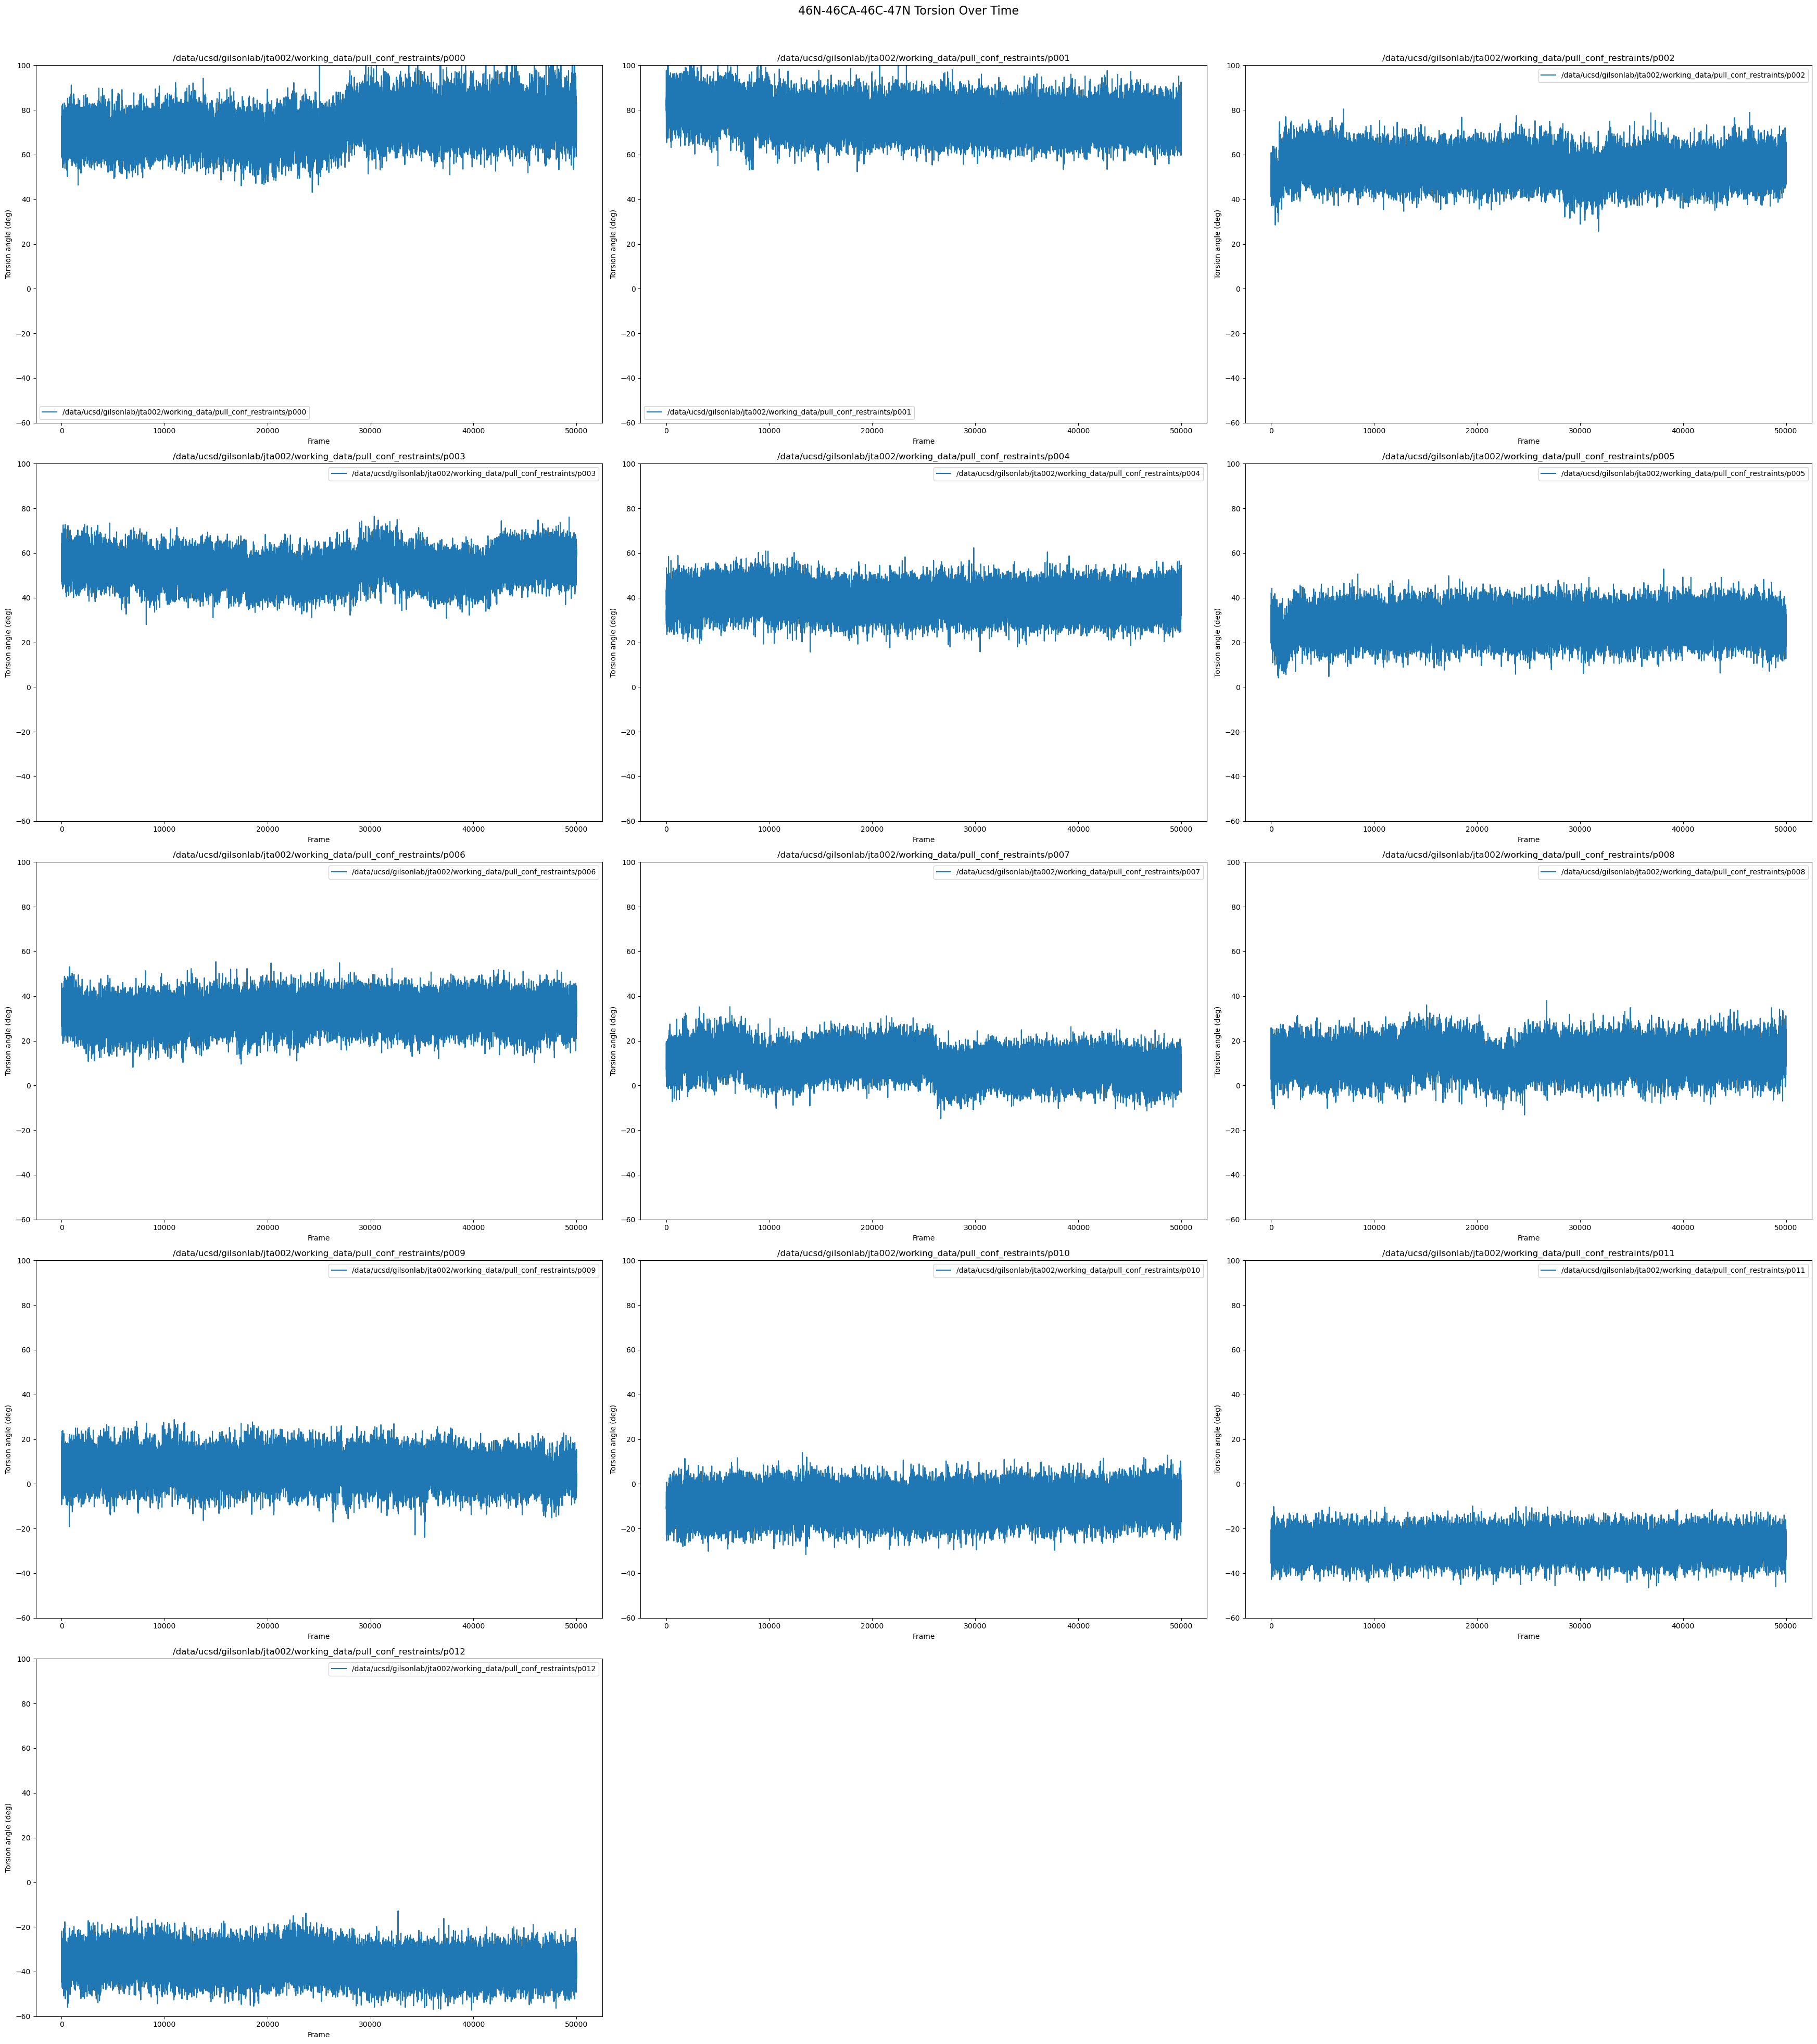

In [42]:
make_graph_of_pull_conf_restraints = True

if make_graph_of_pull_conf_restraints:
    import os

    import matplotlib.pyplot as plt
    import MDAnalysis as mda
    import numpy as np
    from scipy import stats

    # Parameters
    # "p000" to "p012"
    directories = [
        f"{working_data}/pull_conf_restraints/{window}"
        for window in [f"p{str(i).zfill(3)}" for i in range(13)]
    ]

    # Set up subplots
    fig, axes = plt.subplots(
        5, 3, figsize=(35, 40)
    )  # Larger figure size (5x3 grid for 13 plots)
    axes = axes.flatten()

    # Loop over directories
    for idx, directory in enumerate(directories):
        # Load trajectory and topology
        pdb_file = os.path.join(directory, "minimized.pdb")
        dcd_file = os.path.join(directory, "production.dcd")

        if not os.path.exists(pdb_file) or not os.path.exists(dcd_file):
            print(f"Skipping {directory}, files not found.")
            continue

        u = mda.Universe(pdb_file, dcd_file)

        # Select atoms for torsion angle
        atoms = u.select_atoms(
            "resid 46 and name N",
            "resid 46 and name CA",
            "resid 46 and name C",
            "resid 47 and name N",
        )

        # Initialize a list to store torsion angles
        torsions = []

        # Loop through the trajectory and compute torsions
        for ts in u.trajectory:
            torsion_angle = atoms.dihedral.value()
            torsions.append(torsion_angle)

        torsions = np.array(torsions)
        avg_torsion_value = np.mean(torsions)
        sem = stats.sem(torsions)
        print(
            f"Average torsion value for {directory}: {avg_torsion_value:.2f} +/- {sem:.2f} degrees"
        )

        frames = np.arange(len(torsions))  # Frame range for raw data

        # Plotting raw torsion angles on respective subplot
        ax = axes[idx]
        ax.plot(frames, torsions, label=f"{directory}")
        ax.set_title(f"{directory}")
        ax.set_xlabel("Frame")
        ax.set_ylabel("Torsion angle (deg)")
        ax.set_ylim(bottom=-60, top=100)

        ax.legend()

    # Remove unused subplots (since we only need 13 out of 16)
    for i in range(len(directories), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave some room for titles
    plt.suptitle("46N-46CA-46C-47N Torsion Over Time", fontsize=16)
    plt.savefig("torsions_during_conf_pull.png", dpi=600)
    plt.show()

In [34]:
import paprika.analysis as analysis

free_energy = analysis.fe_calc()
free_energy.topology = "heated.pdb"
free_energy.trajectory = "production.dcd"
free_energy.path = f"{working_data}/pull_conf_restraints"
free_energy.restraint_list = pull_conf_restraints_dynamic
free_energy.collect_data(single_topology=False)
free_energy.methods = ["mbar-autoc"]
free_energy.boot_cycles = 1000
free_energy.compute_free_energy(phases=["pull"])
free_energy.save_results(f"{results_dirname}/deltaG_pull_conf.json", overwrite=True)

deltaG_pull_conf = {
   "fe": free_energy.results["pull"]["mbar-autoc"]["fe"],
   "sem": free_energy.results["pull"]["mbar-autoc"]["sem"],
   "fe_matrix": free_energy.results["pull"]["mbar-autoc"]["fe_matrix"],
   "sem_matrix": free_energy.results["pull"]["mbar-autoc"]["sem_matrix"],
}
deltaG_values["deltaG_pull_conf"] = deltaG_pull_conf
print(deltaG_pull_conf)

2024-12-15 08:44:14 PM Reached a solution to within tolerance with hybr
2024-12-15 08:44:14 PM Solution found within tolerance!
2024-12-15 08:44:14 PM Final gradient norm: 7.07e-10
2024-12-15 08:44:16 PM Reached a solution to within tolerance with hybr
2024-12-15 08:44:16 PM Solution found within tolerance!
2024-12-15 08:44:16 PM Final gradient norm: 7.07e-10


{'fe': <Quantity(-6.08769517, 'kilocalorie / mole')>, 'sem': <Quantity(0.0126396119, 'kilocalorie / mole')>, 'fe_matrix': <Quantity([[ 0.         -0.41945991 -1.21449673 ... -6.41003145 -6.21332844
  -6.08769517]
 [ 0.41945991  0.         -0.79503682 ... -5.99057154 -5.79386853
  -5.66823526]
 [ 1.21449673  0.79503682  0.         ... -5.19553471 -4.9988317
  -4.87319844]
 ...
 [ 6.41003145  5.99057154  5.19553471 ...  0.          0.19670301
   0.32233628]
 [ 6.21332844  5.79386853  4.9988317  ... -0.19670301  0.
   0.12563327]
 [ 6.08769517  5.66823526  4.87319844 ... -0.32233628 -0.12563327
   0.        ]], 'kilocalorie / mole')>, 'sem_matrix': <Quantity([[0.         0.00247965 0.00555499 ... 0.01137546 0.01205181 0.01263961]
 [0.00247965 0.         0.00404114 ... 0.01070583 0.0114219  0.01204049]
 [0.00555499 0.00404114 0.         ... 0.00935727 0.01016875 0.01085897]
 ...
 [0.01137546 0.01070583 0.00935727 ... 0.         0.00291085 0.00472705]
 [0.01205181 0.0114219  0.01016875 ... 

## Calculate $\Delta G_{conf,release}$

In [35]:
from paprika import restraints
from paprika.restraints.openmm import apply_dat_restraint, apply_positional_restraints

from openmm.app import PDBFile

for i in range(0, 1000):
    open_conf_path = f"{working_data}/pull_conf_restraints/p{i:03}/production.pdb"
    if os.path.exists(open_conf_path):
        pass
    else:
        open_conf_path = f"{working_data}/pull_conf_restraints/p{i-1:03}/production.pdb"
        break

open_conf_path = f"{prepared_data}/aligned_dummy_structure_protein_only_open_conf.pdb"
pdb = PDBFile(open_conf_path)
model.positions = pdb.positions
aligned_dummy_structure.positions = pdb.positions

release_conf_fractions = attach_conf_fractions[::-1]

release_conf_restraints_static = []

release_conf_restraints_dynamic = []

P1_P2_distance = restraints.DAT_restraint()
P1_P2_distance.mask1 = P1
P1_P2_distance.mask2 = P2
P1_P2_distance.topology = aligned_dummy_structure
P1_P2_distance.auto_apr = False
P1_P2_distance.continuous_apr = False
P1_P2_distance.amber_index = False
P1_P2_vector = (
    aligned_dummy_structure[P2].positions[0] - aligned_dummy_structure[P1].positions[0]
)
P1_P2_vector = [val.value_in_unit(angstrom) for val in P1_P2_vector]
P1_P2_distance.release["target"] = openff_unit.Quantity(
    value=np.linalg.norm(P1_P2_vector), units=openff_unit.angstrom
)
P1_P2_distance.release["fraction_list"] = release_conf_fractions * 100
P1_P2_distance.release["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
P1_P2_distance.initialize()

release_conf_restraints_dynamic.append(P1_P2_distance)


P2_P3_distance = restraints.DAT_restraint()
P2_P3_distance.mask1 = P2
P2_P3_distance.mask2 = P3
P2_P3_distance.topology = aligned_dummy_structure
P2_P3_distance.auto_apr = False
P2_P3_distance.continuous_apr = False
P2_P3_distance.amber_index = False
P2_P3_vector = (
    aligned_dummy_structure[P3].positions[0] - aligned_dummy_structure[P2].positions[0]
)
P2_P3_vector = [val.value_in_unit(angstrom) for val in P2_P3_vector]
P2_P3_distance.release["target"] = openff_unit.Quantity(
    value=np.linalg.norm(P2_P3_vector), units=openff_unit.angstrom
)
P2_P3_distance.release["fraction_list"] = release_conf_fractions * 100
P2_P3_distance.release["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
P2_P3_distance.initialize()

release_conf_restraints_dynamic.append(P2_P3_distance)


P1_P3_distance = restraints.DAT_restraint()
P1_P3_distance.mask1 = P1
P1_P3_distance.mask2 = P3
P1_P3_distance.topology = aligned_dummy_structure
P1_P3_distance.auto_apr = False
P1_P3_distance.continuous_apr = False
P1_P3_distance.amber_index = False
P1_P3_vector = (
    aligned_dummy_structure[P3].positions[0] - aligned_dummy_structure[P1].positions[0]
)
P1_P3_vector = [val.value_in_unit(angstrom) for val in P1_P3_vector]
P1_P3_distance.release["target"] = openff_unit.Quantity(
    value=np.linalg.norm(P1_P3_vector), units=openff_unit.angstrom
)
P1_P3_distance.release["fraction_list"] = release_conf_fractions * 100
P1_P3_distance.release["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
P1_P3_distance.initialize()

release_conf_restraints_dynamic.append(P1_P3_distance)


Asp88_torsion = restraints.DAT_restraint()
Asp88_torsion.mask1 = ASP88_1
Asp88_torsion.mask2 = ASP88_2
Asp88_torsion.mask3 = ASP88_3
Asp88_torsion.mask4 = ASP88_4
Asp88_torsion.topology = aligned_dummy_structure
Asp88_torsion.auto_apr = False
Asp88_torsion.continuous_apr = False
Asp88_torsion.amber_index = False
Asp88_torsion.release["target"] = -40  # Degrees
Asp88_torsion.release["fraction_list"] = release_conf_fractions * 100
Asp88_torsion.release["fc_final"] = 20  # kilocalorie/(mole*radian**2)
Asp88_torsion.initialize()

release_conf_restraints_dynamic.append(Asp88_torsion)

list_of_backbone_atom_masks = []

i = 85
atom_names = itertools.cycle(["C", "N", "CA"])
while i <= 98:
    atom_name = next(atom_names)
    list_of_backbone_atom_masks.append(f":{i-42}@{atom_name}")
    if atom_name == "C":
        i += 1
list_of_backbone_atom_masks.append(f":{99-42}@N")

torsion_targets = iter(torsion_targets)

i = 0
for masks in zip(
    list_of_backbone_atom_masks,
    list_of_backbone_atom_masks[1:],
    list_of_backbone_atom_masks[2:],
    list_of_backbone_atom_masks[3:],
):
    i += 1
    if i % 3 == 0:
        continue
    is_asp88_phi = (masks[1] == f":{88-42}@N") and (masks[2] == f":{88-42}@CA")
    is_asp88_psi = (masks[1] == f":{88-42}@CA") and (masks[2] == f":{88-42}@C")
    is_asp96_phi = (masks[1] == f":{96-42}@N") and (masks[2] == f":{96-42}@CA")
    is_asp96_psi = (masks[1] == f":{96-42}@CA") and (masks[2] == f":{96-42}@C")
    if True in [is_asp88_phi, is_asp88_psi, is_asp96_phi, is_asp96_psi]:
        continue

    torsion = restraints.DAT_restraint()
    torsion.mask1, torsion.mask2, torsion.mask3, torsion.mask4 = masks
    torsion.topology = aligned_dummy_structure
    torsion.auto_apr = False
    torsion.continuous_apr = False
    torsion.amber_index = False
    vec1 = np.array( 
        torsion.topology[torsion.mask2].positions[0].value_in_unit(angstrom)
    ) - np.array(torsion.topology[torsion.mask1].positions[0].value_in_unit(angstrom))
    vec2 = np.array(
        torsion.topology[torsion.mask3].positions[0].value_in_unit(angstrom)
    ) - np.array(torsion.topology[torsion.mask2].positions[0].value_in_unit(angstrom))
    vec3 = np.array(
        torsion.topology[torsion.mask4].positions[0].value_in_unit(angstrom)
    ) - np.array(torsion.topology[torsion.mask3].positions[0].value_in_unit(angstrom))
    norm1, norm2 = np.cross(vec1, vec2), np.cross(vec2, vec3)
    # torsion.release["target"] = np.degrees(np.arccos(np.dot(norm1, norm2) / (np.linalg.norm(norm1) * np.linalg.norm(norm2))))
    torsion.release["target"] = next(torsion_targets)
    torsion.release["fraction_list"] = release_conf_fractions * 100
    torsion.release["fc_final"] = 50  # kilocalorie/(mole*radian**2)
    torsion.initialize()

    release_conf_restraints_dynamic.append(torsion)

release_conf_restraints_dynamic = release_conf_restraints_dynamic[::2]
release_conf_restraints_dynamic.pop(2)

# Check restraints and create windows from dynamic restraints
restraints.restraints.check_restraints(release_conf_restraints_dynamic)
window_list = restraints.utils.create_window_list(release_conf_restraints_dynamic)

2024-12-15 08:44:25 PM Restraints appear to be consistent
2024-12-15 08:44:25 PM Restraints appear to be consistent


In [36]:
from simulate import run_heating_and_equil, run_minimization, run_production

simulation_parameters = {
    "k_pos": 50 * kilocalorie / (mole * angstrom**2),
    "friction": 1 / picosecond,
    "timestep": 1 * femtoseconds,
    "tolerance": 0.001 * kilojoules_per_mole / nanometer,
    "maxIterations": 0,
}

# futures = [
#     run_minimization.remote(
#         window,
#         system,
#         model,
#         release_conf_restraints_dynamic,
#         "release_conf_restraints",
#         simulation_parameters=simulation_parameters,
#         data_dir_names=data_dir_names,
#         suffix="_protein_only",
#     )
#     for window in window_list
# ]
# _ = ray.get(futures)

simulation_parameters = {
    "temperatures": np.arange(0.0, 298.15, 1.0),
    "time_per_temp": 20 * picoseconds,
    "equilibration_time": 40 * nanoseconds,
    "friction": 1 / picosecond,
    "timestep": 0.5 * femtoseconds,
}

# futures = [
#     run_heating_and_equil.remote(
#         window,
#         system,
#         model,
#         "release_conf_restraints",
#         simulation_parameters=simulation_parameters,
#         data_dir_names=data_dir_names,
#         suffix="_protein_only",
#     )
#     for window in window_list
# ]
# _ = ray.get(futures)

simulation_parameters = {
    "temperature": 298.15,
    "friction": 1 / picosecond,
    "timestep": 1 * femtoseconds,
    "production_time": 100 * nanoseconds,
    "dcd_reporter_frequency": 1000,
    "state_reporter_frequency": 1000,
    "suffix": "_protein_only",
}

# futures = [
#     run_production.remote(
#         window,
#         system,
#         model,
#         "release_conf_restraints",
#         simulation_parameters=simulation_parameters,
#         data_dir_names=data_dir_names,
#         suffix="_protein_only",
#     )
#     for window in window_list
# ]
# _ = ray.get(futures)

In [37]:
import paprika.analysis as analysis

free_energy = analysis.fe_calc()
free_energy.topology = "heated.pdb"
free_energy.trajectory = "production.dcd"
free_energy.path = f"{working_data}/release_conf_restraints"
free_energy.restraint_list = release_conf_restraints_dynamic
free_energy.collect_data(single_topology=False)
free_energy.methods = ["mbar-autoc"]
free_energy.boot_cycles = 1000
free_energy.compute_free_energy(phases=["release"])
free_energy.save_results(f"{results_dirname}/deltaG_release_conf.json", overwrite=True)

deltaG_release_conf = {
   "fe": free_energy.results["release"]["mbar-autoc"]["fe"],
   "sem": free_energy.results["release"]["mbar-autoc"]["sem"],
   "fe_matrix": free_energy.results["release"]["mbar-autoc"]["fe_matrix"],
   "sem_matrix": free_energy.results["release"]["mbar-autoc"]["sem_matrix"],
}
deltaG_values["deltaG_release_conf"] = deltaG_release_conf
print(deltaG_release_conf)

2024-12-15 09:05:25 PM Reached a solution to within tolerance with hybr
2024-12-15 09:05:25 PM Solution found within tolerance!
2024-12-15 09:05:25 PM Final gradient norm: 2.14e-09
2024-12-15 09:05:57 PM Reached a solution to within tolerance with hybr
2024-12-15 09:05:57 PM Solution found within tolerance!
2024-12-15 09:05:57 PM Final gradient norm: 2.14e-09


{'fe': <Quantity(29.911242, 'kilocalorie / mole')>, 'sem': <Quantity(0.0082533571, 'kilocalorie / mole')>, 'fe_matrix': <Quantity([[  0.           5.48217439   7.55884119 ...  28.88229572  29.43355623
   29.91124202]
 [ -5.48217439   0.           2.0766668  ...  23.40012134  23.95138184
   24.42906763]
 [ -7.55884119  -2.0766668    0.         ...  21.32345454  21.87471504
   22.35240083]
 ...
 [-28.88229572 -23.40012134 -21.32345454 ...   0.           0.5512605
    1.0289463 ]
 [-29.43355623 -23.95138184 -21.87471504 ...  -0.5512605    0.
    0.47768579]
 [-29.91124202 -24.42906763 -22.35240083 ...  -1.0289463   -0.47768579
    0.        ]], 'kilocalorie / mole')>, 'sem_matrix': <Quantity([[0.         0.00526642 0.00625922 ... 0.00818342 0.00821957 0.00825336]
 [0.00526642 0.         0.00221291 ... 0.00571157 0.00576324 0.00581133]
 [0.00625922 0.00221291 0.         ... 0.00498854 0.00504762 0.00510246]
 ...
 [0.00818342 0.00571157 0.00498854 ... 0.         0.00029949 0.00057458]
 [0.0

## Calculate $\Delta G_{release,p,cl}$

In [38]:
from paprika import restraints
from paprika.restraints.openmm import apply_dat_restraint, apply_positional_restraints

from openmm.app import PDBFile

closed_conf_path = f"{prepared_data}/aligned_dummy_structure_protein_only.pdb"
pdb = PDBFile(closed_conf_path)
model.positions = pdb.positions
aligned_dummy_structure.positions = pdb.positions

release_conf_fractions = attach_conf_fractions[::-1]

release_conf_restraints_static = []

Asp88_torsion_static = restraints.static_DAT_restraint(
    [ASP88_1, ASP88_2, ASP88_3, ASP88_4],
    [0, 0, len(release_conf_fractions)],
    "prepared_data/aligned_dummy_structure_protein_only.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
Asp88_torsion_static.custom_restraint_values = {
    "r2": 55 * openff_unit.degrees,
    "r3": 179.9 * openff_unit.degrees,
    "rk2": 20 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    "rk3": 0.0 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
}

release_conf_restraints_static.append(Asp88_torsion_static)

release_conf_restraints_dynamic = []

P1_P2_distance = restraints.DAT_restraint()
P1_P2_distance.mask1 = P1
P1_P2_distance.mask2 = P2
P1_P2_distance.topology = aligned_dummy_structure
P1_P2_distance.auto_apr = False
P1_P2_distance.continuous_apr = False
P1_P2_distance.amber_index = False
P1_P2_vector = (
    aligned_dummy_structure[P2].positions[0] - aligned_dummy_structure[P1].positions[0]
)
P1_P2_vector = [val.value_in_unit(angstrom) for val in P1_P2_vector]
P1_P2_distance.release["target"] = openff_unit.Quantity(
    value=np.linalg.norm(P1_P2_vector), units=openff_unit.angstrom
)
P1_P2_distance.release["fraction_list"] = release_conf_fractions * 100
P1_P2_distance.release["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
P1_P2_distance.initialize()

release_conf_restraints_dynamic.append(P1_P2_distance)


P2_P3_distance = restraints.DAT_restraint()
P2_P3_distance.mask1 = P2
P2_P3_distance.mask2 = P3
P2_P3_distance.topology = aligned_dummy_structure
P2_P3_distance.auto_apr = False
P2_P3_distance.continuous_apr = False
P2_P3_distance.amber_index = False
P2_P3_vector = (
    aligned_dummy_structure[P3].positions[0] - aligned_dummy_structure[P2].positions[0]
)
P2_P3_vector = [val.value_in_unit(angstrom) for val in P2_P3_vector]
P2_P3_distance.release["target"] = openff_unit.Quantity(
    value=np.linalg.norm(P2_P3_vector), units=openff_unit.angstrom
)
P2_P3_distance.release["fraction_list"] = release_conf_fractions * 100
P2_P3_distance.release["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
P2_P3_distance.initialize()

release_conf_restraints_dynamic.append(P2_P3_distance)


P1_P3_distance = restraints.DAT_restraint()
P1_P3_distance.mask1 = P1
P1_P3_distance.mask2 = P3
P1_P3_distance.topology = aligned_dummy_structure
P1_P3_distance.auto_apr = False
P1_P3_distance.continuous_apr = False
P1_P3_distance.amber_index = False
P1_P3_vector = (
    aligned_dummy_structure[P3].positions[0] - aligned_dummy_structure[P1].positions[0]
)
P1_P3_vector = [val.value_in_unit(angstrom) for val in P1_P3_vector]
P1_P3_distance.release["target"] = openff_unit.Quantity(
    value=np.linalg.norm(P1_P3_vector), units=openff_unit.angstrom
)
P1_P3_distance.release["fraction_list"] = release_conf_fractions * 100
P1_P3_distance.release["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
P1_P3_distance.initialize()

release_conf_restraints_dynamic.append(P1_P3_distance)


Asp88_torsion = restraints.DAT_restraint()
Asp88_torsion.mask1 = ASP88_1
Asp88_torsion.mask2 = ASP88_2
Asp88_torsion.mask3 = ASP88_3
Asp88_torsion.mask4 = ASP88_4
Asp88_torsion.topology = aligned_dummy_structure
Asp88_torsion.auto_apr = False
Asp88_torsion.continuous_apr = False
Asp88_torsion.amber_index = False
Asp88_torsion.release["target"] = 80  # Degrees
Asp88_torsion.release["fraction_list"] = release_conf_fractions * 100
Asp88_torsion.release["fc_final"] = 20  # kilocalorie/(mole*radian**2)
Asp88_torsion.initialize()

release_conf_restraints_dynamic.append(Asp88_torsion)


# Check restraints and create windows from dynamic restraints
restraints.restraints.check_restraints(release_conf_restraints_static)
restraints.restraints.check_restraints(release_conf_restraints_dynamic)
window_list = restraints.utils.create_window_list(release_conf_restraints_dynamic)

2024-12-15 09:06:05 PM Restraints appear to be consistent
2024-12-15 09:06:05 PM Restraints appear to be consistent
2024-12-15 09:06:05 PM Restraints appear to be consistent


In [39]:
from simulate import run_heating_and_equil, run_minimization, run_production

simulation_parameters = {
    "k_pos": 50 * kilocalorie / (mole * angstrom**2),
    "friction": 1 / picosecond,
    "timestep": 1 * femtoseconds,
    "tolerance": 0.001 * kilojoules_per_mole / nanometer,
    "maxIterations": 0,
}

# futures = [
#     run_minimization.remote(
#         window,
#         system,
#         model,
#         release_conf_restraints_dynamic,
#         "release_conf_restraints_wall",
#         simulation_parameters=simulation_parameters,
#         data_dir_names=data_dir_names,
#         suffix="_protein_only",
#     )
#     for window in window_list
# ]
# _ = ray.get(futures)

simulation_parameters = {
    "temperatures": np.arange(0.0, 298.15, 1.0),
    "time_per_temp": 20 * picoseconds,
    "equilibration_time": 40 * nanoseconds,
    "friction": 1 / picosecond,
    "timestep": 0.5 * femtoseconds,
}

# futures = [
#     run_heating_and_equil.remote(
#         window,
#         system,
#         model,
#         "release_conf_restraints_wall",
#         simulation_parameters=simulation_parameters,
#         data_dir_names=data_dir_names,
#         suffix="_protein_only",
#     )
#     for window in window_list
# ]
# _ = ray.get(futures)

simulation_parameters = {
    "temperature": 298.15,
    "friction": 1 / picosecond,
    "timestep": 1 * femtoseconds,
    "production_time": 100 * nanoseconds,
    "dcd_reporter_frequency": 1000,
    "state_reporter_frequency": 1000,
    "suffix": "_protein_only",
}

# futures = [
#     run_production.remote(
#         window,
#         system,
#         model,
#         "release_conf_restraints_wall",
#         simulation_parameters=simulation_parameters,
#         data_dir_names=data_dir_names,
#         suffix="_protein_only",
#     )
#     for window in window_list
# ]
# _ = ray.get(futures)

In [40]:
import paprika.analysis as analysis

free_energy = analysis.fe_calc()
free_energy.topology = "heated.pdb"
free_energy.trajectory = "production.dcd"
free_energy.path = f"{working_data}/release_conf_restraints_wall"
free_energy.restraint_list = release_conf_restraints_dynamic
free_energy.collect_data(single_topology=False)
free_energy.methods = ["mbar-autoc"]
free_energy.boot_cycles = 1000
free_energy.compute_free_energy(phases=["release"])
free_energy.save_results(f"{results_dirname}/deltaG_release_conf_wall.json", overwrite=True)

deltaG_release_conf_wall = {
   "fe": free_energy.results["release"]["mbar-autoc"]["fe"],
   "sem": free_energy.results["release"]["mbar-autoc"]["sem"],
   "fe_matrix": free_energy.results["release"]["mbar-autoc"]["fe_matrix"],
   "sem_matrix": free_energy.results["release"]["mbar-autoc"]["sem_matrix"],
}
deltaG_values["deltaG_release_conf_wall"] = deltaG_release_conf_wall
print(deltaG_release_conf_wall)

2024-12-15 09:13:38 PM Reached a solution to within tolerance with hybr
2024-12-15 09:13:38 PM Solution found within tolerance!
2024-12-15 09:13:38 PM Final gradient norm: 1.89e-07
2024-12-15 09:13:52 PM Reached a solution to within tolerance with hybr
2024-12-15 09:13:52 PM Solution found within tolerance!
2024-12-15 09:13:52 PM Final gradient norm: 1.89e-07


{'fe': <Quantity(14.6444871, 'kilocalorie / mole')>, 'sem': <Quantity(0.00709775807, 'kilocalorie / mole')>, 'fe_matrix': <Quantity([[  0.           2.49250928   4.17360128 ...  14.29663797  14.48323219
   14.64448713]
 [ -2.49250928   0.           1.681092   ...  11.80412869  11.99072291
   12.15197784]
 [ -4.17360128  -1.681092     0.         ...  10.12303669  10.30963091
   10.47088584]
 ...
 [-14.29663797 -11.80412869 -10.12303669 ...   0.           0.18659422
    0.34784915]
 [-14.48323219 -11.99072291 -10.30963091 ...  -0.18659422   0.
    0.16125494]
 [-14.64448713 -12.15197784 -10.47088584 ...  -0.34784915  -0.16125494
    0.        ]], 'kilocalorie / mole')>, 'sem_matrix': <Quantity([[0.         0.00228985 0.00362223 ... 0.00704585 0.00707301 0.00709776]
 [0.00228985 0.         0.00171621 ... 0.00619282 0.00622371 0.00625182]
 [0.00362223 0.00171621 0.         ... 0.00557849 0.00561277 0.00564392]
 ...
 [0.00704585 0.00619282 0.00557849 ... 0.         0.00018907 0.00035893]
 [

## Save the results

In [2]:
# if os.path.exists(f"{results_dirname}/results.pickle"):
#     with open(f"{results_dirname}/results.pickle", "rb") as f:
#        deltaG_values = pickle.load(f)

with open(f"{results_dirname}/results.pickle", "wb") as f:
   pickle.dump(deltaG_values, f)

In [3]:
deltaG_values.keys()

dict_keys(['deltaG_attach_p', 'deltaG_attach_l', 'deltaG_pull', 'deltaG_release_l', 'deltaG_attach_conf', 'deltaG_pull_conf', 'deltaG_release_conf', 'deltaG_release_conf_wall', 'deltaG_release_l_std'])

In [4]:
deltaG_values["release_l"] = {}
deltaG_values["release_l"]["fe"] = (deltaG_values["deltaG_release_l"]["fe"]
                                    + deltaG_values["deltaG_release_l_std"]["fe"])
deltaG_values["release_l"]["sem"] = np.sqrt(deltaG_values["deltaG_release_l"]["sem"]**2
                                            + deltaG_values["deltaG_release_l_std"]["sem"]**2)

deltaG_values["release_p"] = {}
deltaG_values["release_p"]["fe"] = (deltaG_values["deltaG_attach_conf"]["fe"]
                                    + deltaG_values["deltaG_pull_conf"]["fe"]
                                    + deltaG_values["deltaG_release_conf"]["fe"])
deltaG_values["release_p"]["sem"] = np.sqrt(deltaG_values["deltaG_attach_conf"]["sem"]**2
                                            + deltaG_values["deltaG_pull_conf"]["sem"]**2
                                            + deltaG_values["deltaG_release_conf"]["sem"]**2)


In [5]:
deltaG_values["total"] = {}
deltaG_values["total"]["fe"] = -1 * (deltaG_values["deltaG_attach_p"]["fe"]
                                     + deltaG_values["deltaG_attach_l"]["fe"]
                                     + deltaG_values["deltaG_pull"]["fe"]
                                     + deltaG_values["release_l"]["fe"]
                                     + deltaG_values["release_p"]["fe"])
deltaG_values["total"]["sem"] = np.sqrt(deltaG_values["deltaG_attach_p"]["sem"]**2
                                       + deltaG_values["deltaG_attach_l"]["sem"]**2
                                       + deltaG_values["deltaG_release_conf"]["sem"]**2
                                       + deltaG_values["release_l"]["sem"]**2
                                       + deltaG_values["release_p"]["sem"]**2)

In [6]:
for key in deltaG_values.keys():
    print(f"{key}\nfe: {deltaG_values[key]['fe']:0.3f}\nsem: {deltaG_values[key]['sem']:0.3f}\n")

deltaG_attach_p
fe: 18.790 kilocalorie / mole
sem: 0.006 kilocalorie / mole

deltaG_attach_l
fe: 45.178 kilocalorie / mole
sem: 0.002 kilocalorie / mole

deltaG_pull
fe: 12.336 kilocalorie / mole
sem: 0.027 kilocalorie / mole

deltaG_release_l
fe: 17.998 kilocalorie / mole
sem: 0.024 kilocalorie / mole

deltaG_attach_conf
fe: 146.281 kilocalorie / mole
sem: 0.095 kilocalorie / mole

deltaG_pull_conf
fe: -6.088 kilocalorie / mole
sem: 0.013 kilocalorie / mole

deltaG_release_conf
fe: 29.911 kilocalorie / mole
sem: 0.008 kilocalorie / mole

deltaG_release_conf_wall
fe: 14.644 kilocalorie / mole
sem: 0.007 kilocalorie / mole

deltaG_release_l_std
fe: 4.641 kilocalorie / mole
sem: 0.000

release_l
fe: 22.639 kilocalorie / mole
sem: 0.024 kilocalorie / mole

release_p
fe: 170.104 kilocalorie / mole
sem: 0.096 kilocalorie / mole

total
fe: -76.304 kilocalorie / mole
sem: 0.011 kilocalorie / mole

